<div style="border-top: 3px solid #0a6d91; padding: 15px; display: flex; align-items: center; justify-content: space-between;">

  <!-- Left text -->
  <div style="flex: 1; padding-right: 20px;">
    <h1 style= display: inline-block; padding: 5px 10px; border-radius: 3px;">
      Mutual Information Dynamics <br> in VAEs
    </h1>
    <h3>Information theory and inference</h3>
  </div>

  <!-- Right images -->
  <div style="flex: 0 0 auto; display: flex; align-items: center; gap: 20px;">
    <img src="https://th.bing.com/th/id/R.f158dd00f7e0e326ff081cf1acb39901?rik=tfJW%2frH3keCJ%2fg&riu=http%3a%2f%2fboostlab.dfa.unipd.it%2fimg%2flogo_pod.png&ehk=Th6GDiUuQTgD%2faBhIK7JUi15%2bG%2f35LzMJV9PFEPd9rg%3d&risl=&pid=ImgRaw&r=0" alt="PoD" width="250"/>
    <img src="https://www.unidformazione.com/wp-content/uploads/2018/04/unipd-universita-di-padova-1024x463.png" alt="UNIPD" width = "350" />
  </div>

</div>
<div style="border-bottom: 1px solid #0a6d91">
  <p><strong>Authors</strong></p>
  <table style="border-collapse: collapse; display: inline-table;">
    <tr>
      <td style="padding: 1px;">Boscolo Marco</td>
      <td style="padding: 1px;">2157559</td>
    </tr>
    <tr>
      <td style="padding: 1px;">La Rovere Francesco</td>
      <td style="padding: 1px;">2164968</td>
    </tr>
    <tr>
      <td style="padding: 1px;">Montagner Nicolò</td>
      <td style="padding: 1px;">2165809</td>
    </tr>
    <tr>
      <td style="padding: 1px;">Sabatini Raffaele</td>
      <td style="padding: 1px;">2165739</td>
    </tr>
  </table>
</div>

# Theory schema

In [1]:
from IPython.display import Image

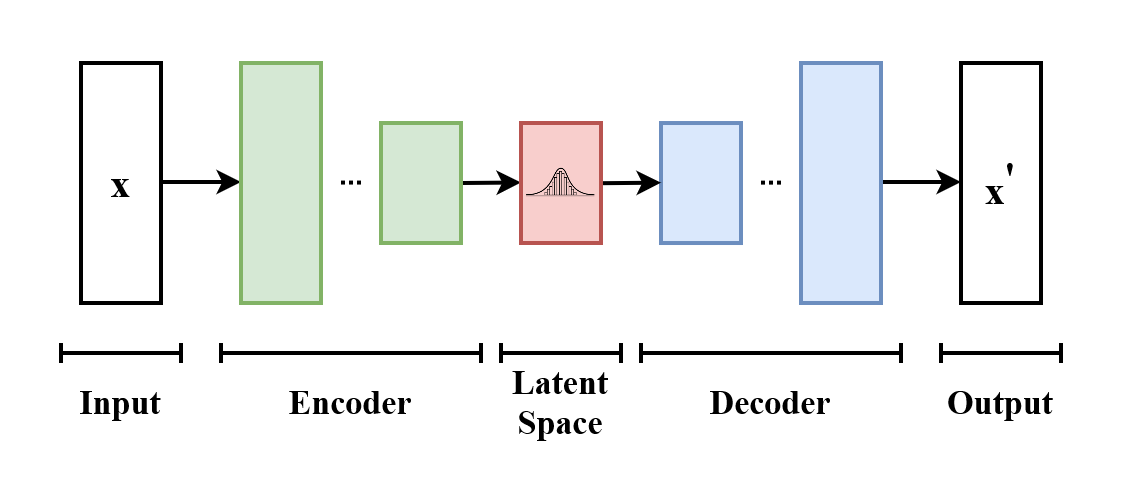

In [2]:
Image(filename="Images/VAE_Basic.png")

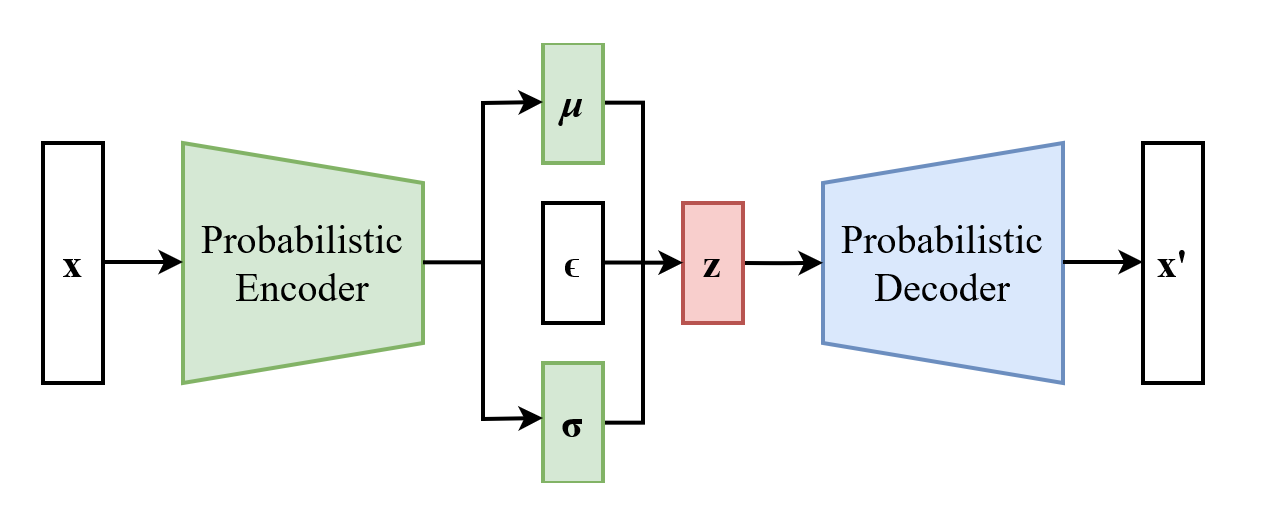

In [3]:
Image(filename="Images/Reparameterized_Variational_Autoencoder.png")

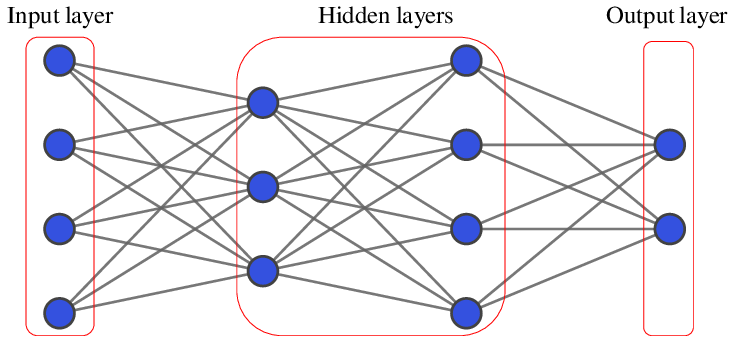

In [4]:
Image(filename="Images/FFNN.png")

# 0. Libraries

In [74]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [75]:
import os
import random
from typing import List
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from tqdm import tqdm
from matplotlib import cm
from matplotlib.colors import Normalize
from matplotlib.lines import Line2D
from scipy.special import digamma
from sklearn.neighbors import NearestNeighbors
from IPython.display import clear_output

import torch
from torch import nn
from torch.utils.data import DataLoader
import torchvision
from torchvision import transforms

from VariationalModel import *

# 1. Set up

## Tracking Layers

In [76]:
class ActivationRecorder:
    def __init__(self):
        self.activations = {} # Current activations
        self.history = {}     # History: history[epoch][layer_name] -> array

    def hook(self, name):
        def _hook(module, inputs, output): # PyTorch hook, module is a layer in the NN
            self.activations[name] = output.detach().cpu().numpy()
        return _hook

    def InitialRegister(self, model):
        self.activations = {}
        self.history = {}

        # Register hooks for Input
        model.InputSpace.register_forward_hook(self.hook("input_space"))
        
        # Register hooks for Encoder
        for i, layer in enumerate(model.Encoder):
            layer.register_forward_hook(self.hook(f"encoder_layer_{i+1}"))

        # Register hooks for Decoder
        for i, layer in enumerate(model.Decoder):
            layer.register_forward_hook(self.hook(f"decoder_layer_{i+1}"))

        # Register Latent and Output
        model.LatentSpace.register_forward_hook(self.hook("latent_space"))
        model.OutputSpace.register_forward_hook(self.hook("output_space"))

    def get(self, name):
        return self.activations[name]

    def save_epoch(self, epoch):
        self.history[epoch] = {k: v.copy() for k, v in self.activations.items()}

In [77]:
class MI_History:
    def __init__(self):
        self.encoder = []
        self.decoder = []
        self.input_latent = []
        self.latent_output = []
    
    def append(self, mi_dict):
        self.encoder.append(mi_dict["encoder"])
        self.decoder.append(mi_dict["decoder"])
        self.input_latent.append(mi_dict["input_latent"])
        self.latent_output.append(mi_dict["latent_output"])

    def show(self, what="all"):
        what = what.lower().strip()
        
        if not self.input_latent:
            print("No history available.")
            return

        print(f"{'='*20} MI HISTORY ({what}) {'='*20}")
        
        for epoch in range(len(self.input_latent)):
            print(f"EPOCH {epoch + 1}")
            
            # --- Global Metrics ---
            if what == "global" or what == "all":
                mi_xz = self.input_latent[epoch]
                mi_zy = self.latent_output[epoch]
                print(f"  [Global] I(Input, Z): {mi_xz:.3f} | I(Z, Output): {mi_zy:.3f}")

            # --- Encoder Layers ---
            if what == "encoder" or what == "all":
                print("  [Encoder]")
                for i, (mi_in, mi_lat) in enumerate(self.encoder[epoch]):
                    print(f"    Layer {i+1}: I(Input, L)={mi_in:.3f} | I(L, Z)={mi_lat:.3f}")
            
            # --- Decoder Layers ---
            if what == "decoder" or what == "all":
                print("  [Decoder]")
                for i, (mi_lat, mi_out) in enumerate(self.decoder[epoch]):
                    print(f"    Layer {i+1}: I(Z, L)={mi_lat:.3f}     | I(L, Output)={mi_out:.3f}")
            
            print("-" * 50)

## Mutual Info Estimation <br> (Kernel Density Estimation and Kraskov-NearestNeighbors-)

In [78]:
class MI_Estimator:
    def __init__(self, method, sigma=1.0, n_neig=3):
        self.method = method
        self.sigma  = sigma
        self.n_neig = n_neig
    
    # ---------------- KDE METHOD ----------------
    def density(self, data):
        N, d = data.shape
        
        data_sq = np.sum(data**2, axis=1, keepdims=True)
        dists_sq = data_sq + data_sq.T - 2 * data @ data.T
        
        sigma_scaled = self.sigma  # self.sigma * np.sqrt(d) (Scale sigma by dimension) ***********************IMP**********************
        
        kernel = np.exp(-dists_sq / (2 * sigma_scaled**2))
        return np.mean(kernel, axis=1)

    def entropy_kde(self, data):
        rho = self.density(data)
        return -np.mean(np.log(rho + 1e-10))

    # ---------------- KRASKOV METHOD ---------------- # MAI TESTATO DA VEDERE!!!!!
    def kraskov_estimation(self, X, Y):
        # Add tiny noise to break ties (crucial for KSG)
        X = X + 1e-10 * np.random.rand(*X.shape)
        Y = Y + 1e-10 * np.random.rand(*Y.shape)
        
        N = X.shape[0]
        XY = np.hstack([X, Y])
        
        # 1. Find k-nearest neighbors in Joint Space (max norm)
        knn = NearestNeighbors(n_neighbors=self.n_neig + 1, metric='chebyshev')
        knn.fit(XY)
        dists, _ = knn.kneighbors(XY)
        
        # Distance to the k-th neighbor
        radii = dists[:, -1]
        
        # 2. Count neighbors in marginal spaces within those radii
        # We need efficient search, so we fit new trees
        knn_x = NearestNeighbors(metric='chebyshev').fit(X)
        knn_y = NearestNeighbors(metric='chebyshev').fit(Y)
        
        # radius_neighbors returns array of arrays of indices
        nx_indices = knn_x.radius_neighbors(X, radius=radii, return_distance=False)
        ny_indices = knn_y.radius_neighbors(Y, radius=radii, return_distance=False)
        
        # Count lengths (subtract 1 because query point is included)
        nx = np.array([len(i) - 1 for i in nx_indices])
        ny = np.array([len(i) - 1 for i in ny_indices])
        
        # 3. KSG Formula
        # MI = psi(k) + psi(N) - <psi(nx+1) + psi(ny+1)>
        mi = (digamma(self.n_neig) + digamma(N) - 
              np.mean(digamma(nx + 1) + digamma(ny + 1)))
              
        return max(0, mi)

    #The idea is to compute:
    #I(X;Z) = H(Z) - H(Z|X)
    #Mutual information only on the stochastic layer (latent layer)
    def LatentMutualInformation(self, mean, logVar):
        
        N, d = mean.shape
        eps = 1e-10
        var = np.exp(logVar) + eps
        avrVar = np.mean(var)

        #Conditional entropy H(Z|X)
        H_ZgivenX = 0.5 * np.mean(np.sum(np.log(2 * np.pi * np.e * var), axis=1))

        #Marginal entropy H(Z)
        squareMean = np.sum(mean**2, axis=1, keepdims=True)
        dists = squareMean + squareMean.T - 2 * mean @ mean.T

        #Exactly as before, but with logs
        logKernels = -dists / (2 * avrVar)
        log_pdf_sum = np.log(np.sum(np.exp(logKernels), axis=1, keepdims=True))
        h_Z = -np.mean(-np.log(N) + log_pdf_sum)

        return h_Z - H_ZgivenX
        
    
    def mutual_information(self, X, Y):
        X = np.asarray(X)
        Y = np.asarray(Y)  
        # Reshape 1D arrays
        if X.ndim == 1: X = X.reshape(-1, 1)
        if Y.ndim == 1: Y = Y.reshape(-1, 1)

        if self.method == "kde":
            HX = self.entropy_kde(X)
            HY = self.entropy_kde(Y)
            HXY = self.entropy_kde(np.concatenate([X, Y], axis=1))
            return HX + HY - HXY

        if self.method == "kraskov":
            return self.kraskov_estimation(X, Y)

In [79]:
def VAE_info(model, dataset, device, epoch, num_samples, mi_estimator, RecorderActivat):
    model.eval()
    model.to(device)
    
    # batch of data to evaluate Mutual Info
    loader = torch.utils.data.DataLoader(dataset, batch_size=num_samples, shuffle=True)
    inputs, _ = next(iter(loader))
    inputs = inputs.to(device)

    with torch.no_grad():
        model(inputs) # Foward pass to get the activation value in RecorderActivat.activations

    RecorderActivat.save_epoch(epoch)

    X = inputs.view(inputs.size(0), -1).cpu().numpy()
    Z = RecorderActivat.get("latent_space")
    Y = RecorderActivat.get("output_space")
        
    mi = {
        "encoder": [],
        "decoder": [],
        "input_latent": None,
        "latent_output": None
    }
    
    # Encoder Layers
    for i in range(len(model.Encoder)):
        layer_name = f"encoder_layer_{i+1}"
        A = RecorderActivat.get(layer_name)
        mi["encoder"].append((
            mi_estimator.mutual_information(A, X), # I(Layer, Input)
            mi_estimator.mutual_information(A, Z)  # I(Layer, Latent)
        ))

    # Decoder Layers
    for i in range(len(model.Decoder)):
        layer_name = f"decoder_layer_{i+1}"
        A = RecorderActivat.get(layer_name)
        mi["decoder"].append((
            mi_estimator.mutual_information(A, Z), # I(Layer, Latent)
            mi_estimator.mutual_information(A, Y)  # I(Layer, Output)
        ))

    mi["input_latent"]  = mi_estimator.mutual_information(X, Z)
    mi["latent_output"] = mi_estimator.mutual_information(Z, Y)
    
    return mi


def LatentVAE_Info(model, dataset, device, epoch, num_samples, mi_estimator, RecorderActivat):
    model.eval()
    model.to(device)

    #Fix the same seed 
    g = torch.Generator()
    g.manual_seed(42)
    
    # batch of data to evaluate Mutual Info
    loader = torch.utils.data.DataLoader(dataset, batch_size=num_samples, shuffle=True, generator=g)
    inputs, _ = next(iter(loader))
    inputs = inputs.to(device)

    with torch.no_grad():
        outputs, z, mean, logVar = model(inputs)

    mean = mean.detach().cpu().numpy()
    logVar = logVar.detach().cpu().numpy()

    mi = mi_estimator.LatentMutualInformation(mean, logVar)

    return mi


## Dataset

In [80]:
if torch.backends.mps.is_available():
   device = torch.device("mps")
elif torch.cuda.is_available():
   device = torch.device("cuda")
else:
   device = torch.device("cpu")

print(f'Selected device: {device}')

Selected device: mps


In [81]:
dataDirectory = 'Dataset'

trainDataset = torchvision.datasets.MNIST(dataDirectory, train=True, download=True)
testDataset  = torchvision.datasets.MNIST(dataDirectory, train=False, download=True)

In [82]:
len(trainDataset)

60000

In [83]:
len(testDataset)

10000

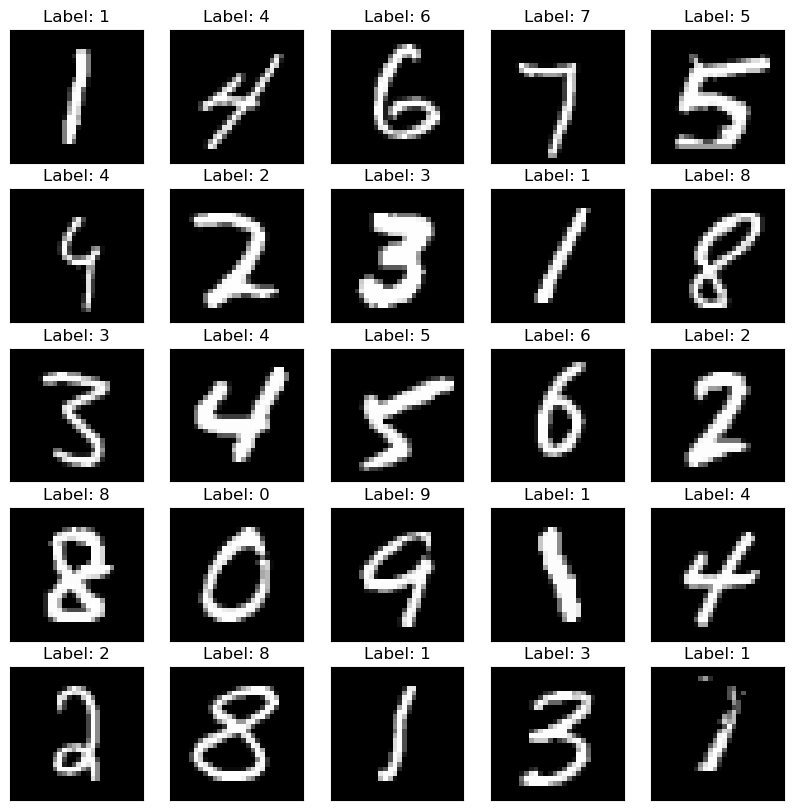

In [84]:
fig, axs = plt.subplots(5, 5, figsize = (10, 10))

for ax in axs.flatten():
   img, label = random.choice(trainDataset)
   ax.imshow(np.array(img), cmap = 'gist_gray')
   ax.set_title(f'Label: {label}')
   ax.set_xticks([])
   ax.set_yticks([])

In [85]:
#Transforms in pytorch tensors
trainTransform = transforms.Compose([transforms.ToTensor(),])
testTransform = transforms.Compose([transforms.ToTensor(),])

trainDataset.transform = trainTransform
testDataset.transform = testTransform

In [86]:
#Define the Dataloader
trainDataloader = DataLoader(trainDataset, batch_size=500, shuffle=True)
testDataloader = DataLoader(testDataset, batch_size=500, shuffle=False)

batch_data, batch_labels = next(iter(trainDataloader))
print(f"TRAIN BATCH SHAPE")
print(f"\t Data: {batch_data.shape}")
print(f"\t Labels: {batch_labels.shape}")

batch_data, batch_labels = next(iter(testDataloader))
print(f"TEST BATCH SHAPE")
print(f"\t Data: {batch_data.shape}")
print(f"\t Labels: {batch_labels.shape}")

TRAIN BATCH SHAPE
	 Data: torch.Size([500, 1, 28, 28])
	 Labels: torch.Size([500])
TEST BATCH SHAPE
	 Data: torch.Size([500, 1, 28, 28])
	 Labels: torch.Size([500])


# 2. VAE model

## Set up model - RELU -

In [87]:
model = VariationalAutoEncoder(latentDim = 10,
                               hiddenDim=[400, 300, 200, 100, 50],
                               activation_enc=nn.ReLU,
                               activation_dec=nn.ReLU,
                               Variational = True
                              )

model.to(device)

VariationalAutoEncoder(
  (InputSpace): Identity()
  (Encoder): Sequential(
    (0): Sequential(
      (0): Linear(in_features=784, out_features=400, bias=True)
      (1): ReLU()
    )
    (1): Sequential(
      (0): Linear(in_features=400, out_features=300, bias=True)
      (1): ReLU()
    )
    (2): Sequential(
      (0): Linear(in_features=300, out_features=200, bias=True)
      (1): ReLU()
    )
    (3): Sequential(
      (0): Linear(in_features=200, out_features=100, bias=True)
      (1): ReLU()
    )
    (4): Sequential(
      (0): Linear(in_features=100, out_features=50, bias=True)
      (1): ReLU()
    )
  )
  (LatentLayerMu): Linear(in_features=50, out_features=10, bias=True)
  (LatentLayerSigma): Linear(in_features=50, out_features=10, bias=True)
  (LatentSpace): Identity()
  (Decoder): Sequential(
    (0): Sequential(
      (0): Linear(in_features=10, out_features=50, bias=True)
      (1): ReLU()
    )
    (1): Sequential(
      (0): Linear(in_features=50, out_features=100, 

In [88]:
optimizer = torch.optim.Adam(model.parameters(), lr=5e-4)
loss_fn = torch.nn.MSELoss()

## Training Model

In [89]:
# global usefull elements

epochs = 200

method_mi="kde"
sigmaKDE = 1
n_neigKRASKOV = 3

RecorderActivat = ActivationRecorder()
mi_history = MI_History()
mi_estimator = MI_Estimator( method=method_mi, sigma=sigmaKDE, n_neig=n_neigKRASKOV )

In [90]:
def Training(model, optimizer, loss_fn, num_epochs, mi_estimator, sampleMI, showImage=False, doTest=False):
    
    # Setting hooks
    RecorderActivat.InitialRegister(model)
    model.to(device)

    LatentMI = []
    
    for epoch in tqdm(range(num_epochs)):
        model.train()
        losses = []
        clear_output(wait=True)
        
        for images, _ in (trainDataloader):#, desc=f"Epoch {epoch+1}/{num_epochs}"):
            images = images.to(device)
            targets = images.view(images.size(0), -1)
            
            outputs, z, mean, logVar = model(images)
            loss = loss_fn(outputs, targets)
            
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
            
            losses.append(loss.item())

        avg_train_loss = np.mean(losses)
        model.train_loss_history.append(avg_train_loss)
        
        # --- Validation Loop ---
        avg_val_loss = None
        if doTest:
            model.eval()
            val_losses = []
            with torch.no_grad():
                for images, _ in testDataloader:
                    images = images.to(device)
                    targets = images.view(images.size(0), -1)
                    outputs, z = model(images)
                    loss = loss_fn(outputs, targets)
                    val_losses.append(loss.item())
            
            avg_val_loss = np.mean(val_losses)
            model.val_loss_history.append(avg_val_loss)

        # --- MI Calculation ---
        res = VAE_info(
            model, 
            trainDataset, 
            device, 
            epoch=epoch, 
            num_samples=sampleMI, 
            mi_estimator=mi_estimator, 
            RecorderActivat=RecorderActivat
        )
        mi_history.append(res)

        test = LatentVAE_Info(model, trainDataset, device, epoch=epoch, num_samples=sampleMI, mi_estimator=mi_estimator, RecorderActivat=RecorderActivat)
        LatentMI.append(test)
        
        # --- Print & Show ---
        val_str = f" — val: {avg_val_loss:.4f}" if avg_val_loss else ""
        print(f"Epoch {epoch+1} — train: {avg_train_loss:.4f}{val_str}")

        if showImage and (epoch % 5 == 0 or epoch == num_epochs - 1):
            model.eval()
            img = testDataset[0][0].unsqueeze(0).to(device)
            with torch.no_grad():
                recon = model(img)[0]
            
            fig, axs = plt.subplots(1, 2, figsize=(6, 3))
            axs[0].imshow(img.cpu().squeeze(), cmap='gray')
            axs[0].set_title("Original")
            axs[1].imshow(recon.cpu().squeeze().view(28, 28), cmap='gray')
            axs[1].set_title("Recon")
            plt.show()
            plt.close()

    return np.mean(losses), LatentMI

In [91]:
final_loss = Training(
    model,
    optimizer,
    loss_fn,
    num_epochs=epochs, 
    sampleMI=500,
    mi_estimator=mi_estimator,
    showImage=False,
    doTest=False
)

Epoch 1/15: 100%|██████████| 120/120 [00:02<00:00, 41.91it/s]


Epoch 1 — train: 0.1013


Epoch 2/15: 100%|██████████| 120/120 [00:02<00:00, 46.61it/s]


Epoch 2 — train: 0.0641


Epoch 3/15: 100%|██████████| 120/120 [00:02<00:00, 48.91it/s]


Epoch 3 — train: 0.0592


Epoch 4/15: 100%|██████████| 120/120 [00:02<00:00, 44.81it/s]


Epoch 4 — train: 0.0539


Epoch 5/15: 100%|██████████| 120/120 [00:02<00:00, 50.09it/s]


Epoch 5 — train: 0.0487


Epoch 6/15: 100%|██████████| 120/120 [00:02<00:00, 50.91it/s]


Epoch 6 — train: 0.0440


Epoch 7/15: 100%|██████████| 120/120 [00:02<00:00, 47.34it/s]


Epoch 7 — train: 0.0402


Epoch 8/15: 100%|██████████| 120/120 [00:02<00:00, 48.78it/s]


Epoch 8 — train: 0.0380


Epoch 9/15: 100%|██████████| 120/120 [00:02<00:00, 51.31it/s]


Epoch 9 — train: 0.0364


Epoch 10/15: 100%|██████████| 120/120 [00:02<00:00, 51.57it/s]


Epoch 10 — train: 0.0348


Epoch 11/15: 100%|██████████| 120/120 [00:02<00:00, 51.13it/s]


Epoch 11 — train: 0.0336


Epoch 12/15: 100%|██████████| 120/120 [00:02<00:00, 48.32it/s]


Epoch 12 — train: 0.0325


Epoch 13/15: 100%|██████████| 120/120 [00:02<00:00, 49.63it/s]


Epoch 13 — train: 0.0316


Epoch 14/15: 100%|██████████| 120/120 [00:02<00:00, 49.34it/s]


Epoch 14 — train: 0.0308


Epoch 15/15: 100%|██████████| 120/120 [00:02<00:00, 44.32it/s]


Epoch 15 — train: 0.0301


In [75]:
final_loss[1]

[np.float64(-17.55531391772161),
 np.float64(8.51844705144038),
 np.float64(52.020208750019336),
 np.float64(60.94319723023836),
 np.float64(71.58117995706323),
 np.float64(79.03791620546674),
 np.float64(90.78452032054683),
 np.float64(94.91870607687255),
 np.float64(99.45774315718283),
 np.float64(101.170049150561),
 np.float64(-inf),
 np.float64(nan),
 np.float64(nan),
 np.float64(nan),
 np.float64(nan),
 np.float64(nan),
 np.float64(nan),
 np.float64(nan),
 np.float64(nan),
 np.float64(nan),
 np.float64(nan),
 np.float64(nan),
 np.float64(nan),
 np.float64(nan),
 np.float64(nan),
 np.float64(nan),
 np.float64(nan),
 np.float64(nan),
 np.float64(nan),
 np.float64(nan),
 np.float64(nan),
 np.float64(nan),
 np.float64(nan),
 np.float64(nan),
 np.float64(nan),
 np.float64(nan),
 np.float64(nan),
 np.float64(nan),
 np.float64(nan),
 np.float64(nan),
 np.float64(nan),
 np.float64(nan),
 np.float64(nan),
 np.float64(nan),
 np.float64(nan),
 np.float64(nan),
 np.float64(nan),
 np.float64(n

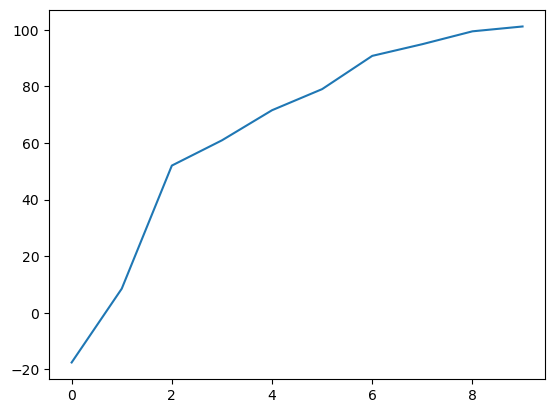

In [74]:
x = np.arange(len(final_loss[1]))
plt.plot(x, final_loss[1])

# 3. Diagnostic

## Inspect elements

### Mutual Information history

In [92]:
#mi_history.show("encoder")

[[(0.8593781, 0.16451621),
  (0.71520853, 0.15243006),
  (0.79128766, 0.17167509),
  (0.93104315, 0.19646323)],
 [(1.943968, 0.62581253),
  (1.8893998, 0.62059784),
  (2.0217555, 0.63685226),
  (2.1408188, 0.6501677)],
 [(1.816047, 0.9187908),
  (1.8101952, 0.9126227),
  (2.041654, 1.0333335),
  (2.2429543, 1.1530018)],
 [(2.86754, 1.470531),
  (2.8679357, 1.4569974),
  (3.244452, 1.6172104),
  (3.4851432, 1.7223248)],
 [(3.8848133, 2.0394764),
  (3.968338, 2.0613246),
  (4.3201237, 2.1936836),
  (4.483773, 2.2574987)],
 [(4.508379, 2.6011953),
  (4.6448836, 2.6588163),
  (4.98798, 2.8307557),
  (5.1163282, 2.8974242)],
 [(4.9250913, 2.9318752),
  (5.096, 3.0187907),
  (5.4193077, 3.1991057),
  (5.4990263, 3.244958)],
 [(4.916162, 3.0995378),
  (5.0847783, 3.1932516),
  (5.418343, 3.4028845),
  (5.507286, 3.4613132)],
 [(5.2610855, 3.3141508),
  (5.4362345, 3.4170294),
  (5.7253137, 3.604123),
  (5.779818, 3.639032)],
 [(5.591489, 3.520587),
  (5.7622757, 3.6225095),
  (5.987946, 3.763

In [93]:
mi_history.show("encoder")

==================== MI HISTORY (encoder) ====================
EPOCH 1
  [Encoder]
    Layer 1: I(Input, L)=2.512 | I(L, Z)=0.765
    Layer 2: I(Input, L)=2.162 | I(L, Z)=0.895
    Layer 3: I(Input, L)=1.798 | I(L, Z)=0.880
    Layer 4: I(Input, L)=1.431 | I(L, Z)=0.819
--------------------------------------------------
EPOCH 2
  [Encoder]
    Layer 1: I(Input, L)=2.315 | I(L, Z)=1.253
    Layer 2: I(Input, L)=2.406 | I(L, Z)=1.808
    Layer 3: I(Input, L)=2.646 | I(L, Z)=2.035
    Layer 4: I(Input, L)=2.396 | I(L, Z)=2.014
--------------------------------------------------
EPOCH 3
  [Encoder]
    Layer 1: I(Input, L)=2.784 | I(L, Z)=1.238
    Layer 2: I(Input, L)=2.840 | I(L, Z)=1.555
    Layer 3: I(Input, L)=3.364 | I(L, Z)=2.005
    Layer 4: I(Input, L)=3.220 | I(L, Z)=2.058
--------------------------------------------------
EPOCH 4
  [Encoder]
    Layer 1: I(Input, L)=3.196 | I(L, Z)=2.070
    Layer 2: I(Input, L)=3.478 | I(L, Z)=2.525
    Layer 3: I(Input, L)=4.484 | I(L, Z)=3.156

In [94]:
#mi_history.show("decoder")

==================== MI HISTORY (decoder) ====================
EPOCH 1
  [Decoder]
    Layer 1: I(Z, L)=0.859     | I(L, Output)=0.165
    Layer 2: I(Z, L)=0.715     | I(L, Output)=0.152
    Layer 3: I(Z, L)=0.791     | I(L, Output)=0.172
    Layer 4: I(Z, L)=0.931     | I(L, Output)=0.196
--------------------------------------------------
EPOCH 2
  [Decoder]
    Layer 1: I(Z, L)=1.944     | I(L, Output)=0.626
    Layer 2: I(Z, L)=1.889     | I(L, Output)=0.621
    Layer 3: I(Z, L)=2.022     | I(L, Output)=0.637
    Layer 4: I(Z, L)=2.141     | I(L, Output)=0.650
--------------------------------------------------
EPOCH 3
  [Decoder]
    Layer 1: I(Z, L)=1.816     | I(L, Output)=0.919
    Layer 2: I(Z, L)=1.810     | I(L, Output)=0.913
    Layer 3: I(Z, L)=2.042     | I(L, Output)=1.033
    Layer 4: I(Z, L)=2.243     | I(L, Output)=1.153
--------------------------------------------------
EPOCH 4
  [Decoder]
    Layer 1: I(Z, L)=2.868     | I(L, Output)=1.471
    Layer 2: I(Z, L)=2.868  

In [95]:
#mi_history.show("global")

==================== MI HISTORY (global) ====================
EPOCH 1
  [Global] I(Input, Z): 1.732 | I(Z, Output): 0.156
--------------------------------------------------
EPOCH 2
  [Global] I(Input, Z): 2.333 | I(Z, Output): 0.621
--------------------------------------------------
EPOCH 3
  [Global] I(Input, Z): 2.198 | I(Z, Output): 0.916
--------------------------------------------------
EPOCH 4
  [Global] I(Input, Z): 3.404 | I(Z, Output): 1.451
--------------------------------------------------
EPOCH 5
  [Global] I(Input, Z): 4.350 | I(Z, Output): 2.011
--------------------------------------------------
EPOCH 6
  [Global] I(Input, Z): 4.887 | I(Z, Output): 2.567
--------------------------------------------------
EPOCH 7
  [Global] I(Input, Z): 5.223 | I(Z, Output): 2.878
--------------------------------------------------
EPOCH 8
  [Global] I(Input, Z): 5.238 | I(Z, Output): 3.041
--------------------------------------------------
EPOCH 9
  [Global] I(Input, Z): 5.478 | I(Z, Outpu

### Activations

In [96]:
# last epoch (check below with all history of activations)
#RecorderActivat.activations

{'input_space': array([[0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        ...,
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.]], dtype=float32),
 'encoder_layer_1': array([[0.29856658, 0.5265994 , 0.18891159, ..., 1.0087752 , 0.        ,
         0.09445059],
        [0.        , 0.48489544, 0.        , ..., 1.4810083 , 0.36148283,
         0.        ],
        [0.        , 0.4340819 , 0.53657675, ..., 0.2728635 , 0.3581162 ,
         0.        ],
        ...,
        [0.        , 0.5290696 , 0.        , ..., 2.9530187 , 0.        ,
         0.        ],
        [0.        , 0.70505166, 0.        , ..., 1.4501926 , 0.7020841 ,
         0.        ],
        [0.        , 1.1254054 , 1.2414325 , ..., 1.5603694 , 0.300902  ,
         0.        ]], dtype=float32),
 'encoder_layer_2': array([[1.6767827, 2.2856357, 2.6051867, ..., 1.960633 , 0.       ,
        

In [97]:
# to check that every epochs activations was saved
assert len(RecorderActivat.history) == epochs #+ 1 (with +1 gives an error)

In [98]:
#RecorderActivat.history

{0: {'input_space': array([[0., 0., 0., ..., 0., 0., 0.],
         [0., 0., 0., ..., 0., 0., 0.],
         [0., 0., 0., ..., 0., 0., 0.],
         ...,
         [0., 0., 0., ..., 0., 0., 0.],
         [0., 0., 0., ..., 0., 0., 0.],
         [0., 0., 0., ..., 0., 0., 0.]], dtype=float32),
  'encoder_layer_1': array([[0.3502542 , 0.7918682 , 0.5940302 , ..., 0.93617415, 0.77534103,
          0.8293041 ],
         [0.        , 0.        , 0.37935653, ..., 0.8282241 , 0.47506115,
          0.738423  ],
         [0.        , 1.2256994 , 0.46991202, ..., 1.1588718 , 1.1443644 ,
          1.2710968 ],
         ...,
         [0.09079168, 0.7361771 , 0.71493113, ..., 0.87960756, 0.82084495,
          1.2847086 ],
         [0.83505076, 0.9971402 , 0.99714655, ..., 1.2132974 , 1.091486  ,
          1.0817205 ],
         [0.        , 1.2238781 , 0.40269366, ..., 1.2360183 , 1.2549431 ,
          0.8537287 ]], dtype=float32),
  'encoder_layer_2': array([[0.94413924, 0.        , 1.4741204 , ..., 1.1

## Distances/distributions of activations

In [99]:
def plot_kde_geometry(recorder, mi_estimator, part="encoder", layer=1, neuron=None, epoch=-1, bins=60):

    if not recorder.history:
        print("No history recorded yet.")
        return

    available_epochs = list(recorder.history.keys())
    if epoch == -1:
        epoch = available_epochs[-1]
    if epoch not in recorder.history:
        print(f"Epoch {epoch} not found in history.")
        return

    if part == "encoder":
        key = f"encoder_layer_{layer}"
    elif part == "decoder":
        key = f"decoder_layer_{layer}"
    elif part == "latent":
        key = "latent_space"
    elif part == "output":
        key = "output_space"
    else:
        print("Part must be 'encoder', 'decoder', 'latent', or 'output'")
        return

    data_dict = recorder.history[epoch]
    if key not in data_dict:
        print(f"Key {key} not found in epoch {epoch}")
        return
        
    X = data_dict[key]

    if neuron is not None:
        X = X[:, neuron:neuron+1]
    
    rho = mi_estimator.density(X)

    X_sq = np.sum(X**2, axis=1, keepdims=True)
    dists_sq = X_sq + X_sq.T - 2 * X @ X.T
    dists = np.sqrt(dists_sq) # dists = np.sqrt(np.maximum(dists_sq, 0))
    tri_idx = np.triu_indices_from(dists, k=1)
    D = dists[tri_idx]

    # for sup-title
    title_str = f"{part}:".upper()
    if part in ["encoder", "decoder"]:
        title_str += f" L{layer}"
    if neuron is not None:
        title_str += f"-N{neuron}"        
    title_str += f" Ep{epoch}"

    fig, axs = plt.subplots(1, 2, figsize=(12, 5))
    fig.suptitle(title_str, fontsize=14)

    axs[0].hist(D, bins=bins, density=True, alpha=0.7, color='gray', edgecolor='black')
    axs[0].set_title("Pairwise Distances")

    axs[1].hist(rho, bins=bins, density=True, alpha=0.7, color='skyblue', edgecolor='black')
    axs[1].set_title("Estimated Density (KDE)")
    
    plt.tight_layout()
    plt.show()

/var/folders/bq/c0v_5_v15yv4wrwpv0d4mc1r0000gn/T/ipykernel_25288/2032468734.py:40: RuntimeWarning: invalid value encountered in sqrt
  dists = np.sqrt(dists_sq) # dists = np.sqrt(np.maximum(dists_sq, 0))


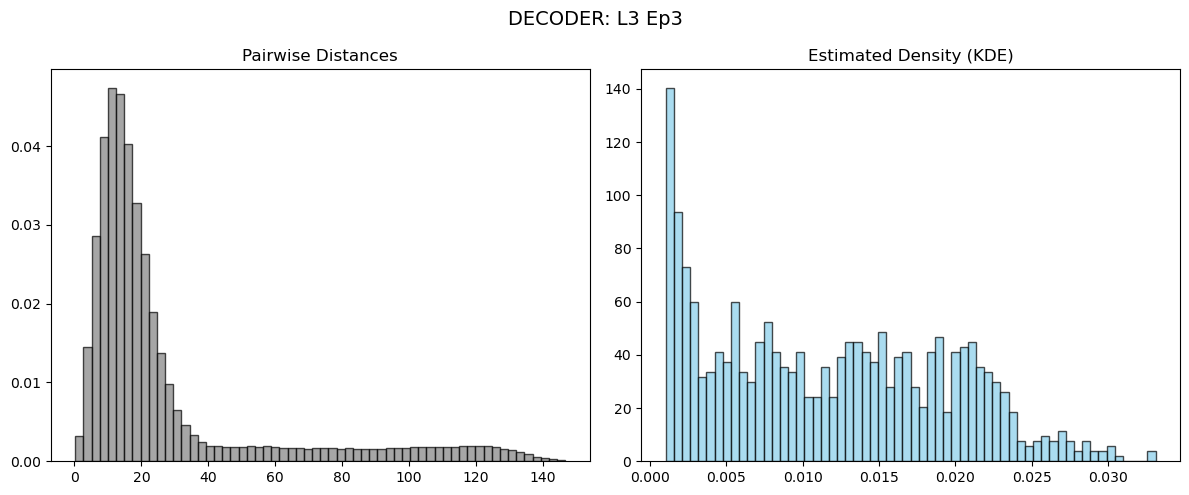

In [100]:
plot_kde_geometry(
    recorder=RecorderActivat,
    mi_estimator=mi_estimator,
    part="decoder",
    layer=3,
    epoch=3
)

/var/folders/bq/c0v_5_v15yv4wrwpv0d4mc1r0000gn/T/ipykernel_25288/2032468734.py:40: RuntimeWarning: invalid value encountered in sqrt
  dists = np.sqrt(dists_sq) # dists = np.sqrt(np.maximum(dists_sq, 0))


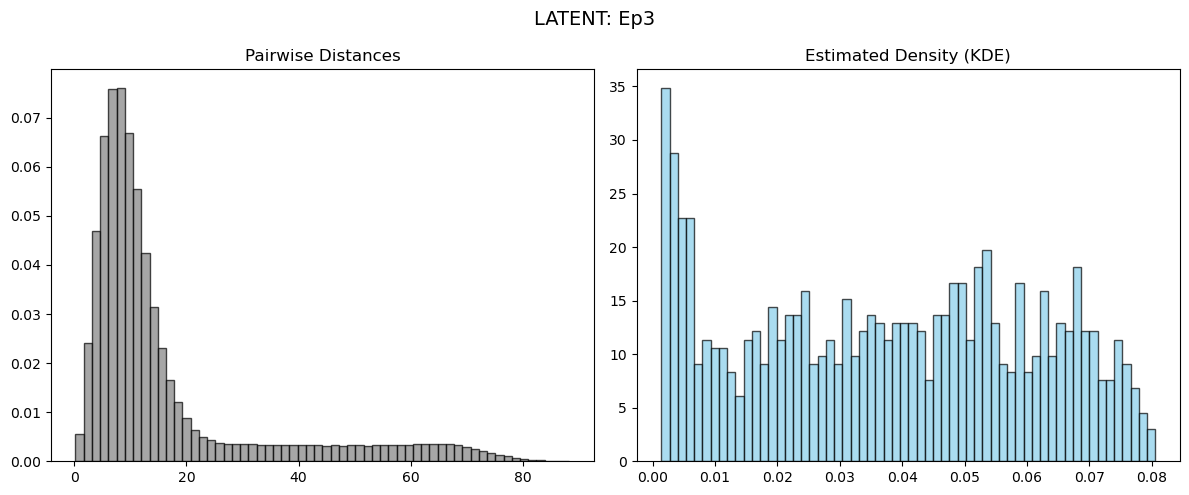

In [101]:
plot_kde_geometry(
    recorder=RecorderActivat,
    mi_estimator=mi_estimator,
    part="latent",
    epoch=3
)

/var/folders/bq/c0v_5_v15yv4wrwpv0d4mc1r0000gn/T/ipykernel_25288/2032468734.py:40: RuntimeWarning: invalid value encountered in sqrt
  dists = np.sqrt(dists_sq) # dists = np.sqrt(np.maximum(dists_sq, 0))


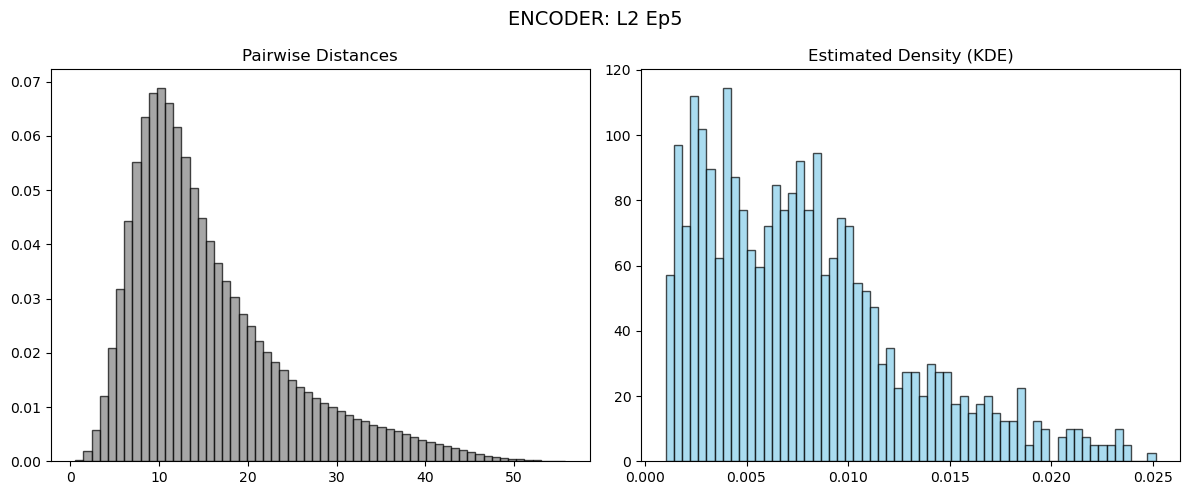

In [102]:
plot_kde_geometry(
    recorder=RecorderActivat,
    mi_estimator=mi_estimator,
    part="encoder",
    layer=2,
    epoch=5
)

/var/folders/bq/c0v_5_v15yv4wrwpv0d4mc1r0000gn/T/ipykernel_25288/2032468734.py:40: RuntimeWarning: invalid value encountered in sqrt
  dists = np.sqrt(dists_sq) # dists = np.sqrt(np.maximum(dists_sq, 0))


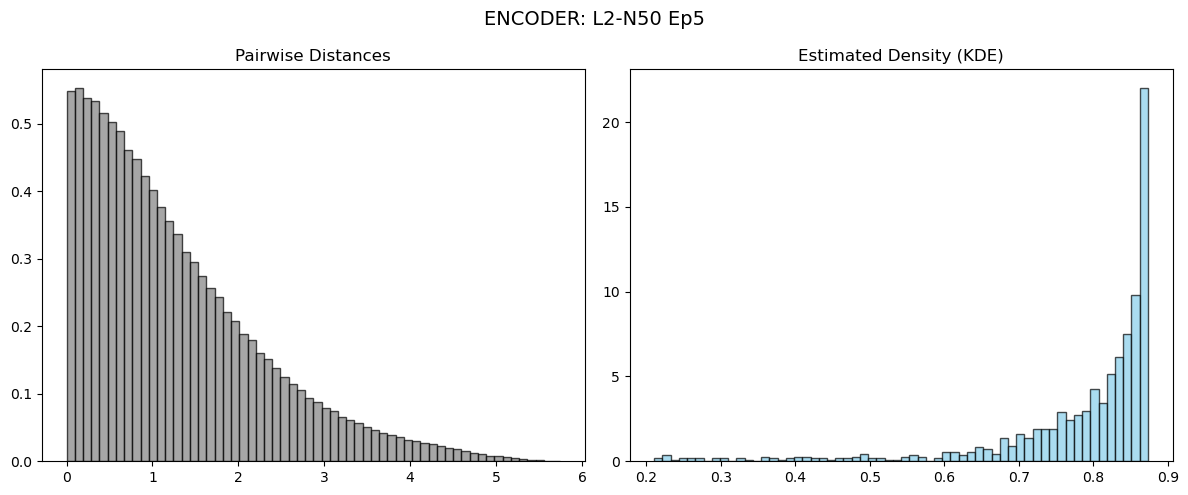

In [103]:
plot_kde_geometry(
    recorder=RecorderActivat,
    mi_estimator=mi_estimator,
    part="encoder",
    layer=2,
    neuron=50,
    epoch=5
)

### ----------    Cicli ignoranti per vedere un po' la situazione ----------

/var/folders/bq/c0v_5_v15yv4wrwpv0d4mc1r0000gn/T/ipykernel_25288/2032468734.py:40: RuntimeWarning: invalid value encountered in sqrt
  dists = np.sqrt(dists_sq) # dists = np.sqrt(np.maximum(dists_sq, 0))


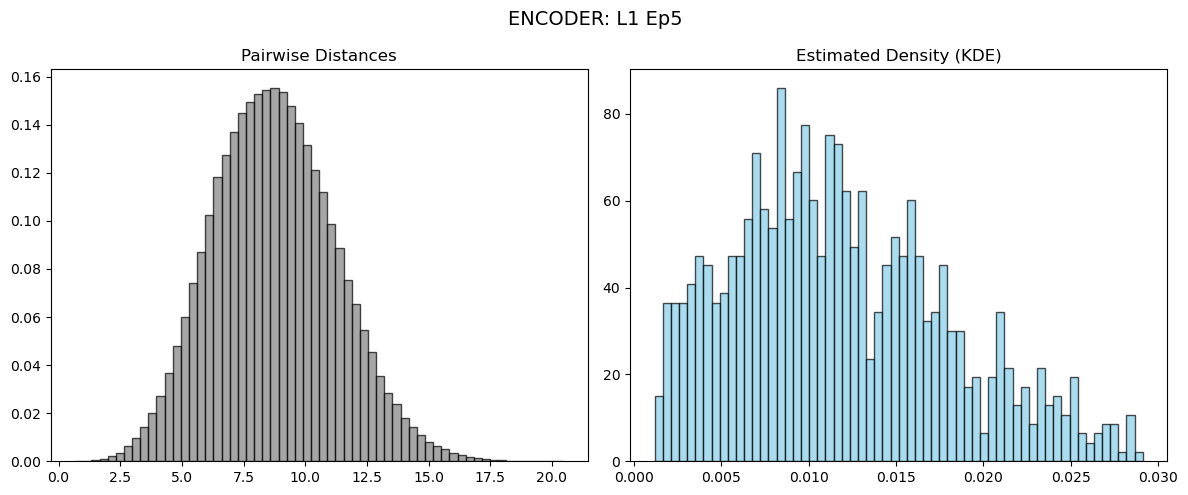

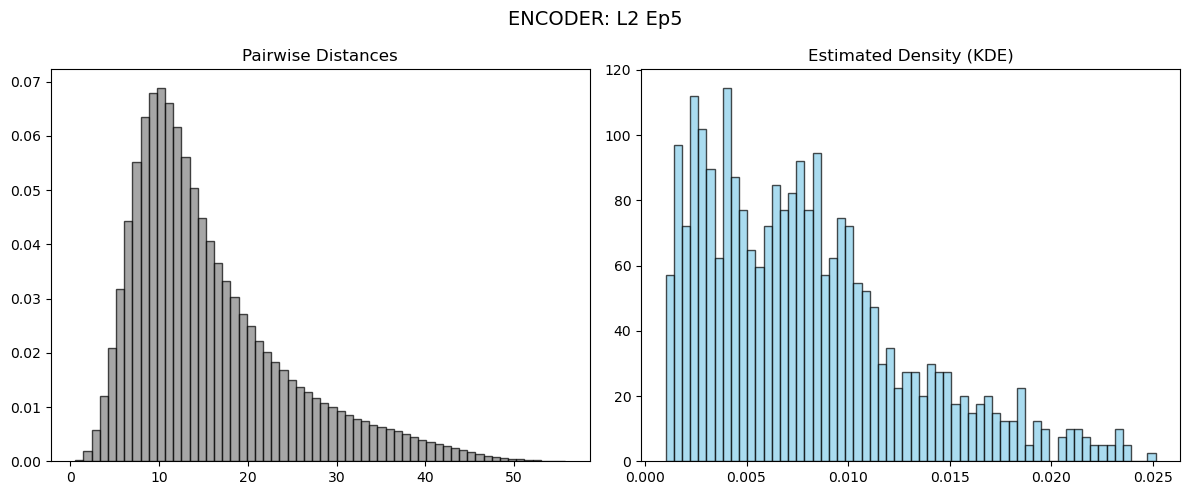

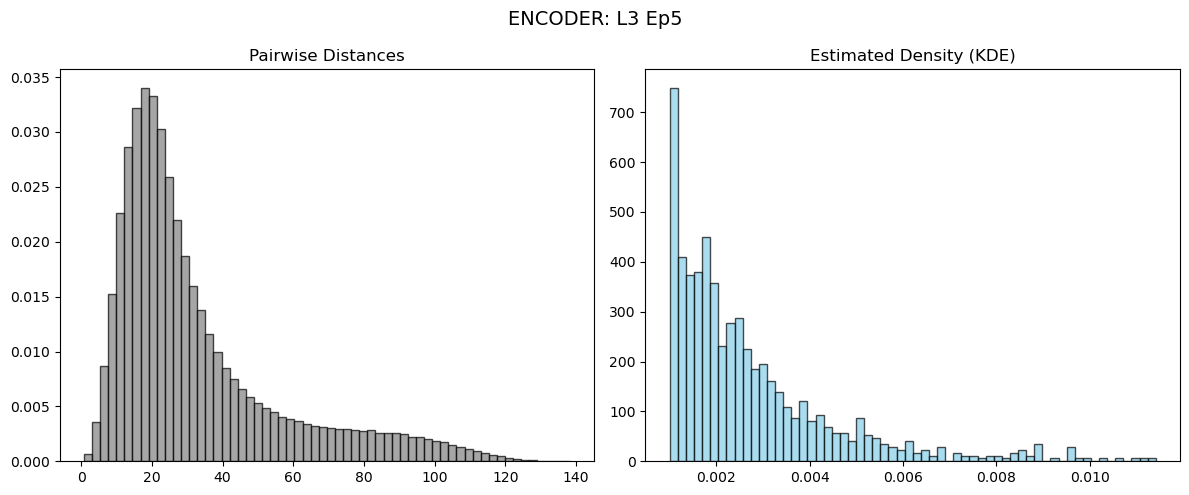

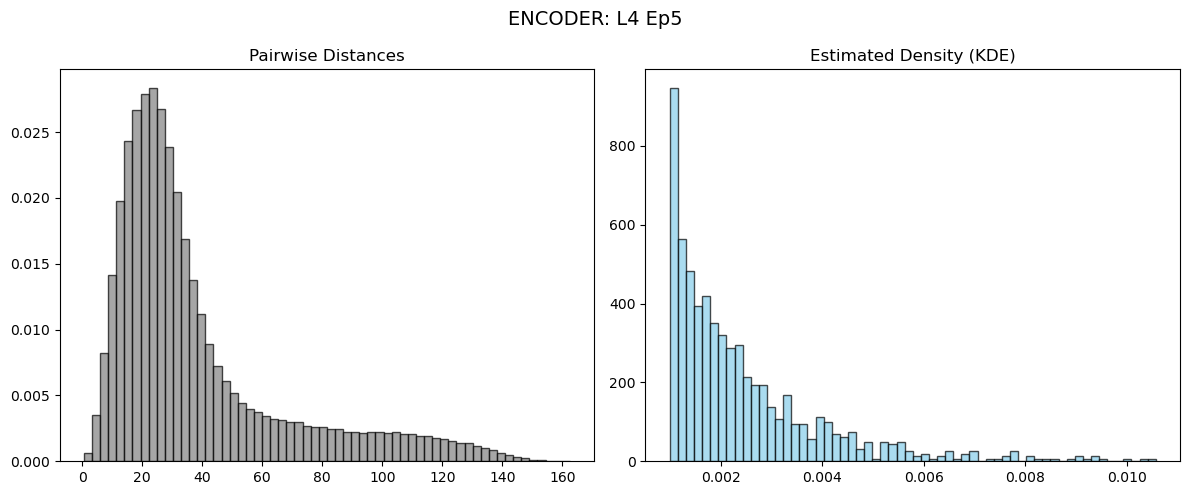

In [104]:
# # sui layer encoder

# for l in range(1, 5):
#     plot_kde_geometry(
#         recorder=RecorderActivat,
#         mi_estimator=mi_estimator,
#         part="encoder",
#         layer=l,
#         epoch=5
#     )

/var/folders/bq/c0v_5_v15yv4wrwpv0d4mc1r0000gn/T/ipykernel_25288/2032468734.py:40: RuntimeWarning: invalid value encountered in sqrt
  dists = np.sqrt(dists_sq) # dists = np.sqrt(np.maximum(dists_sq, 0))


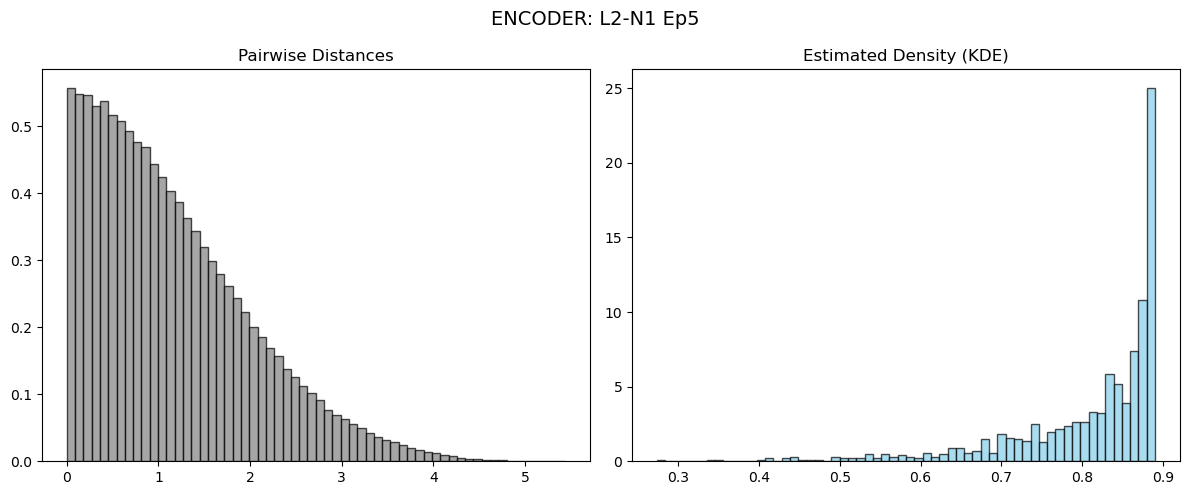

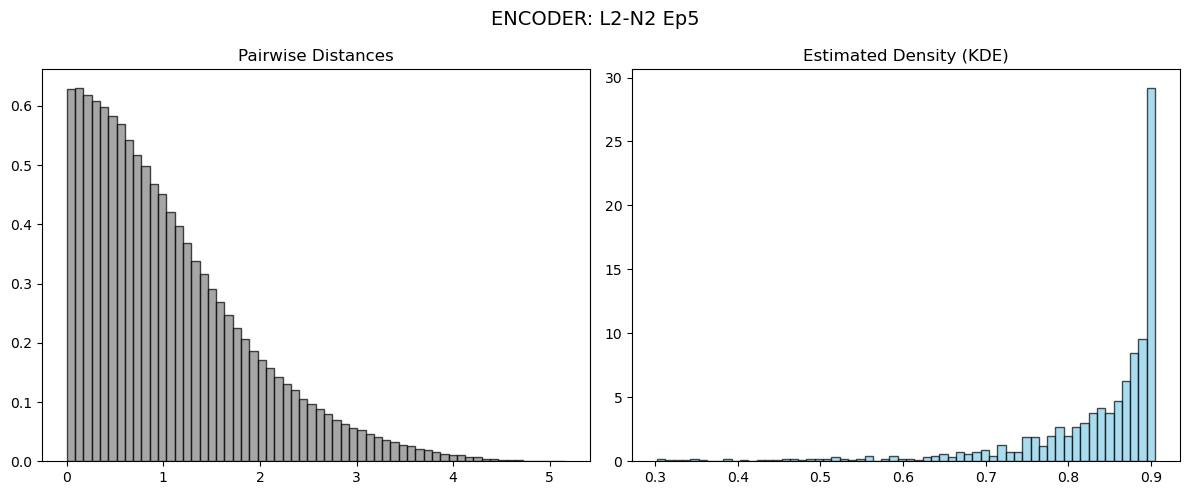

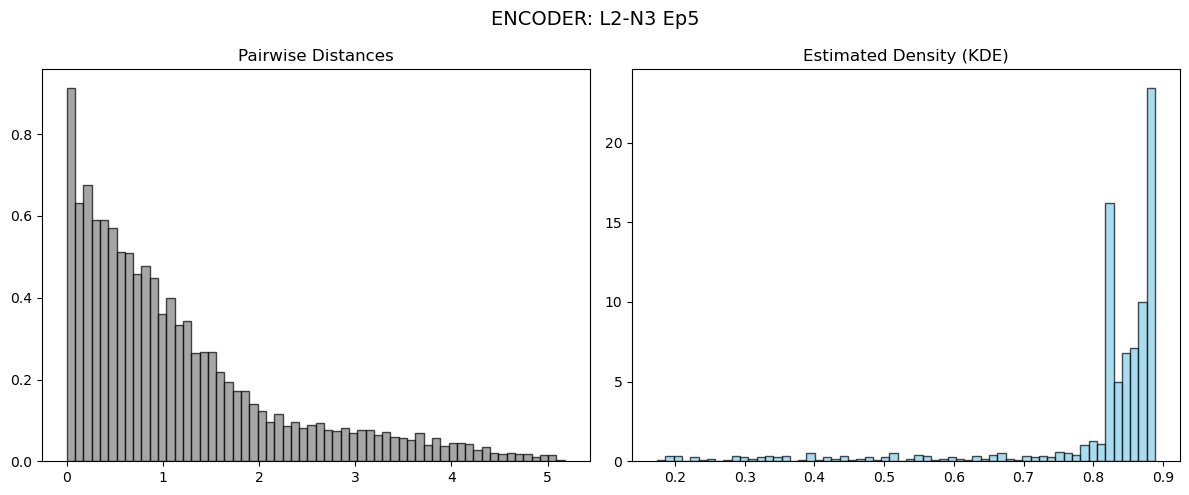

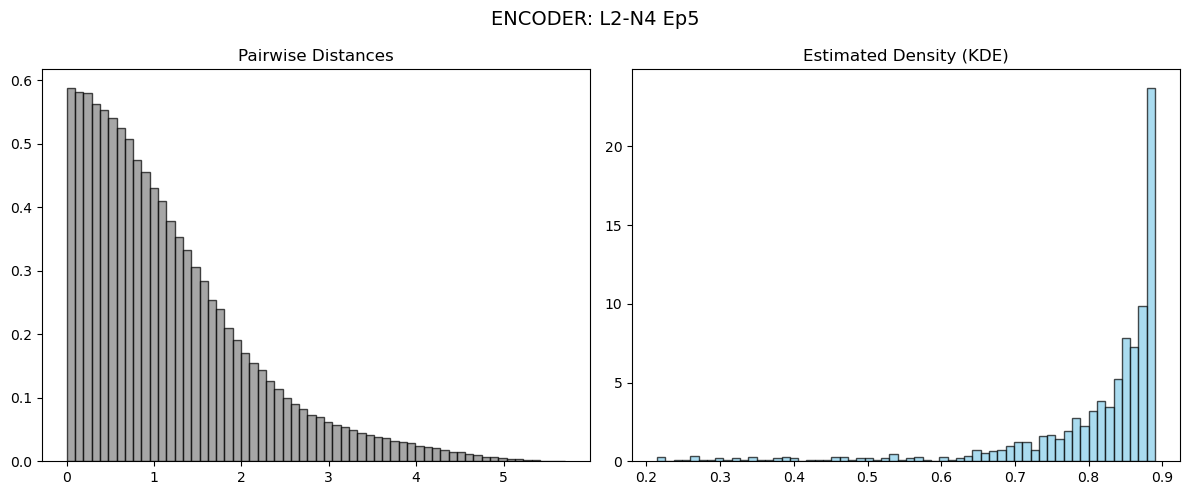

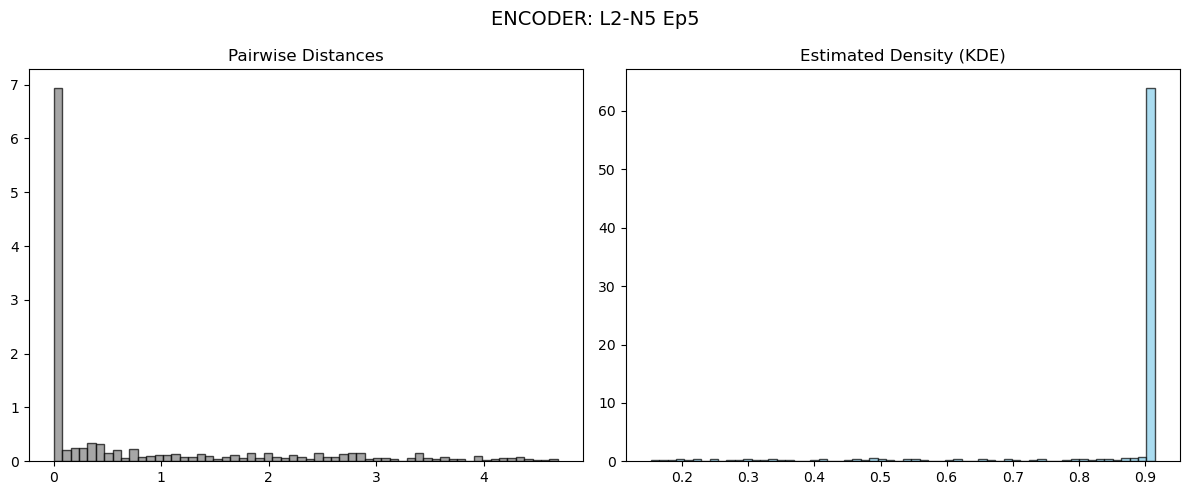

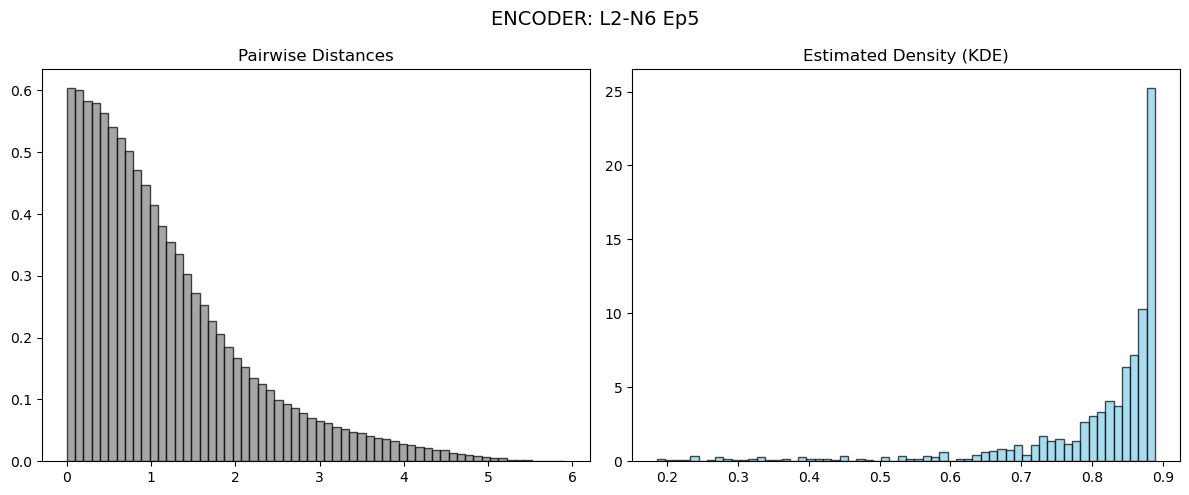

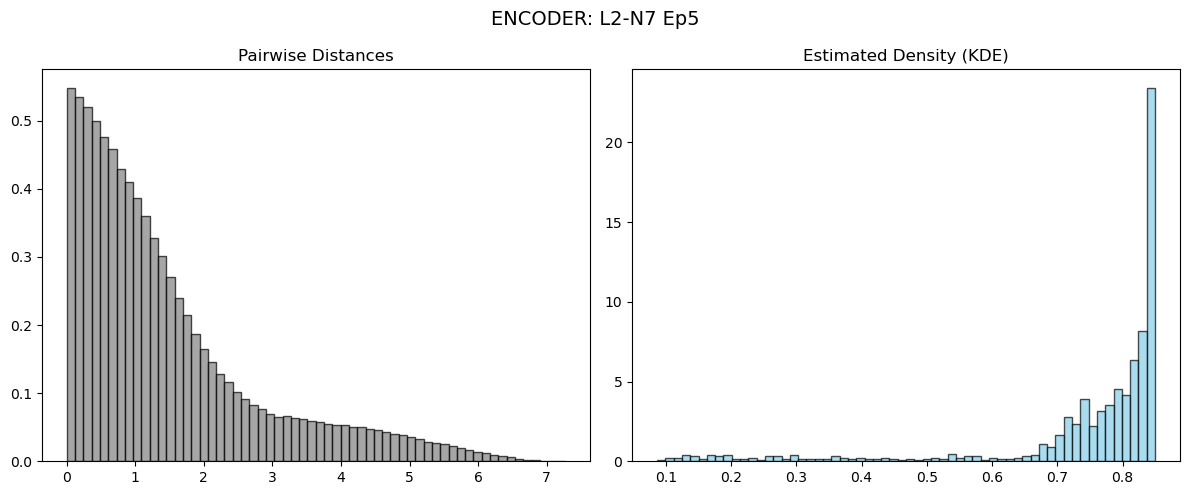

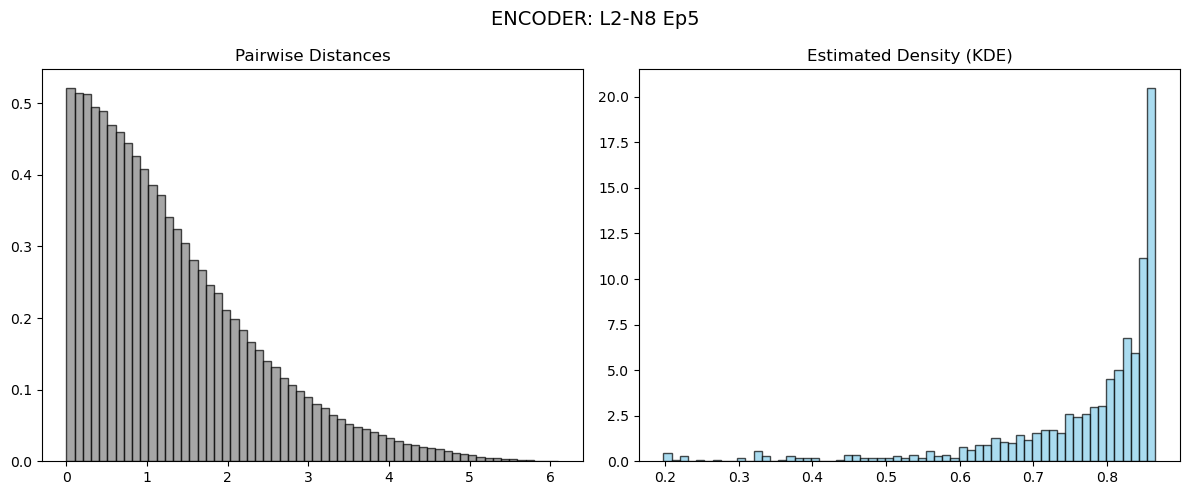

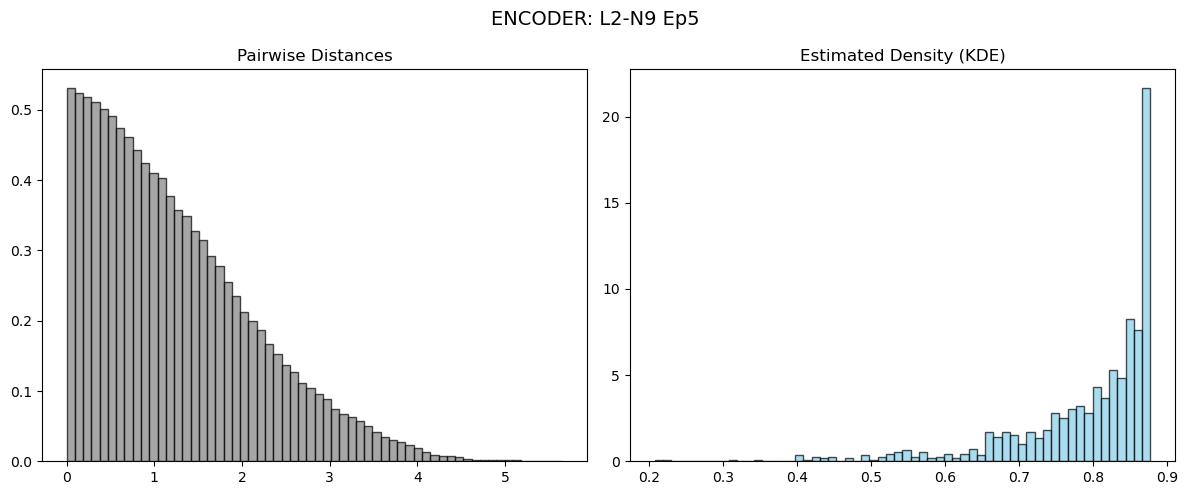

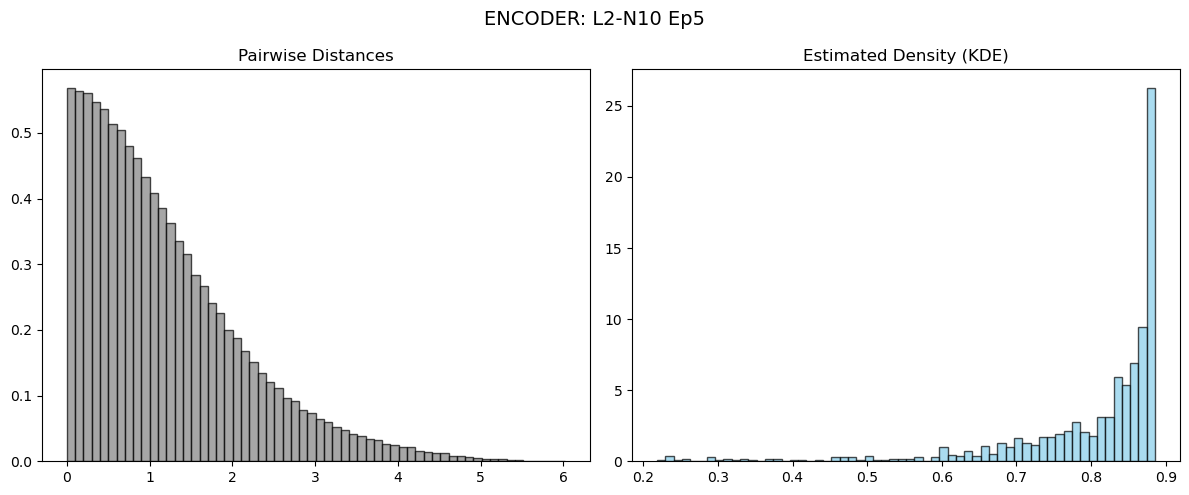

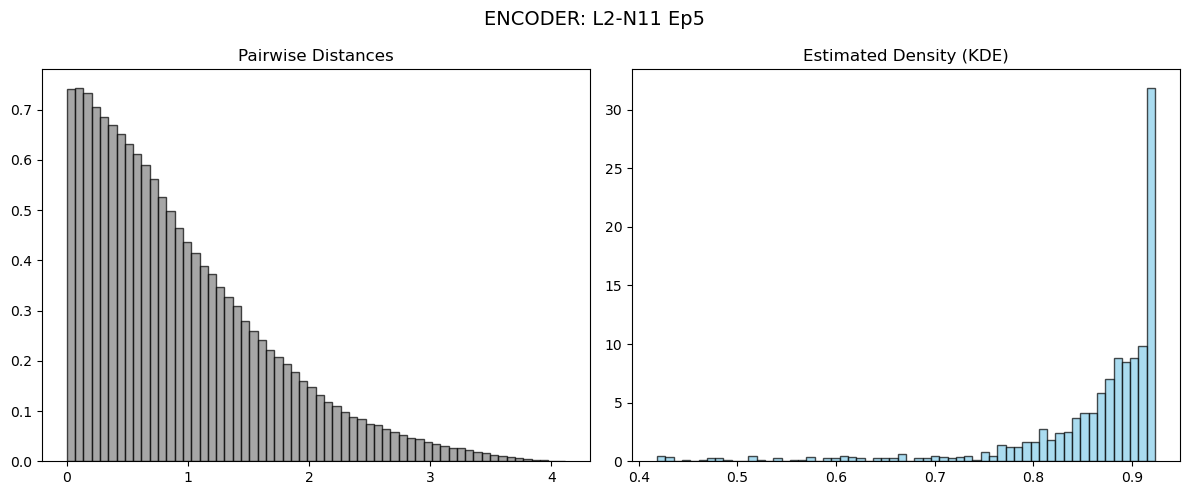

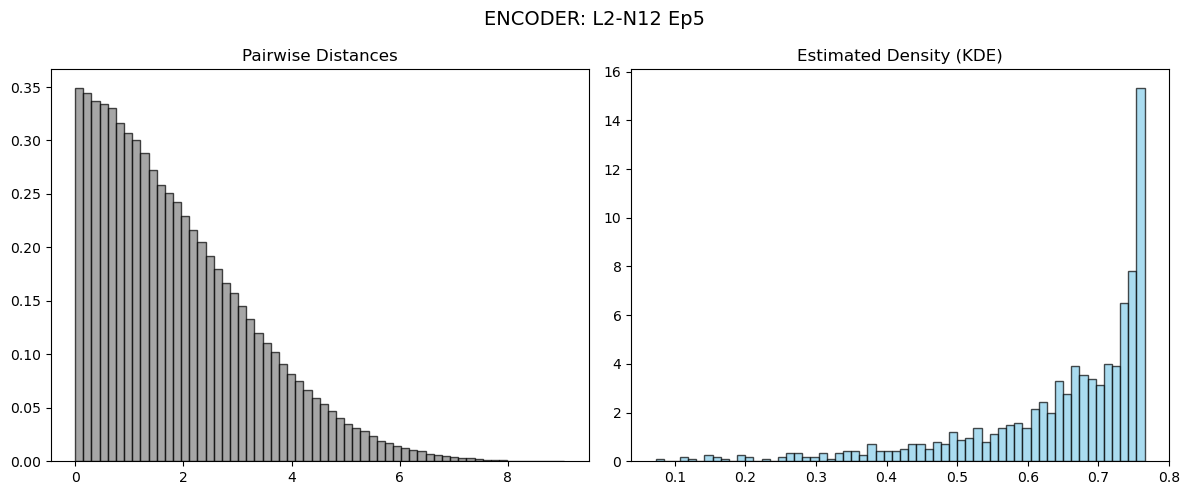

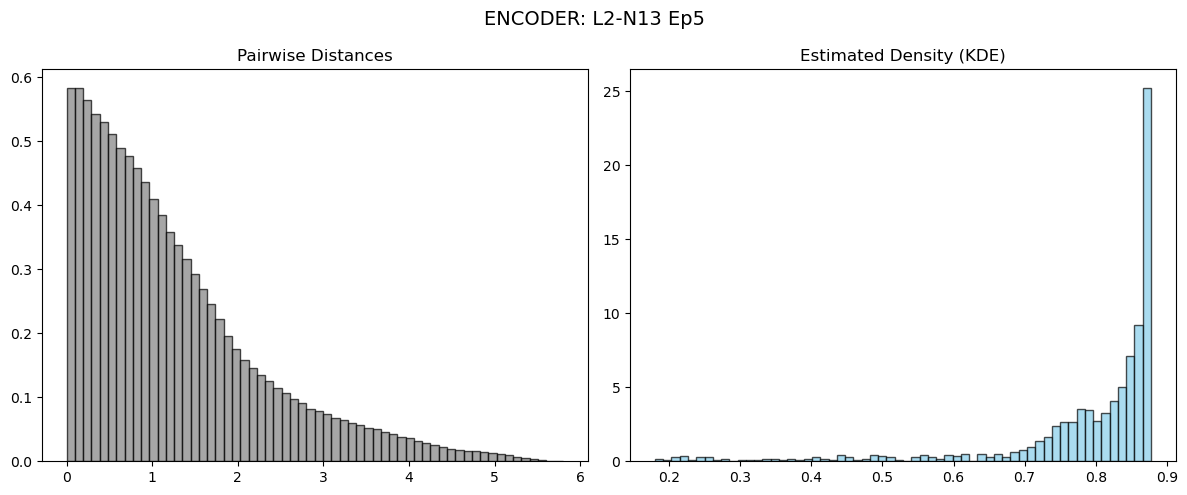

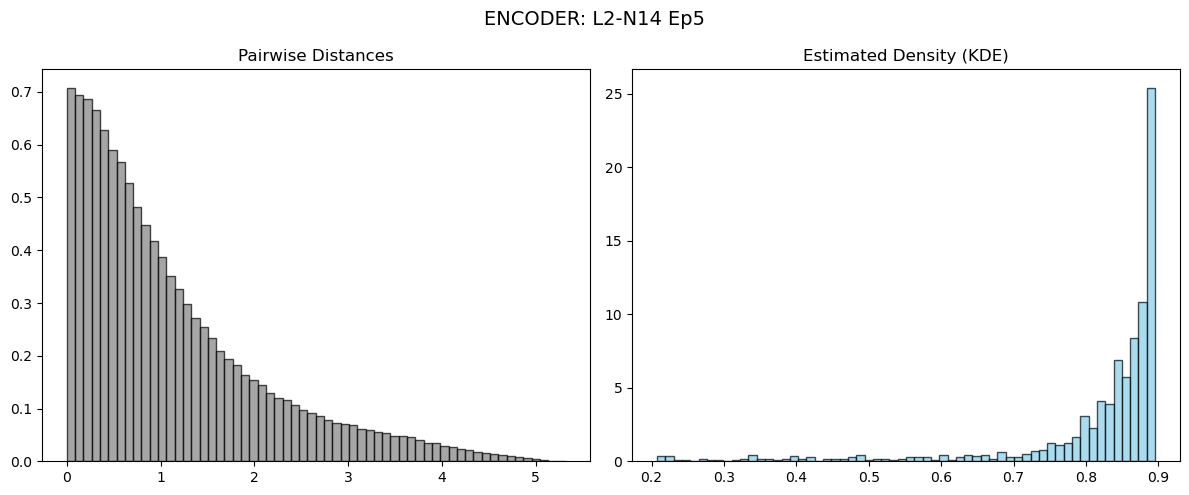

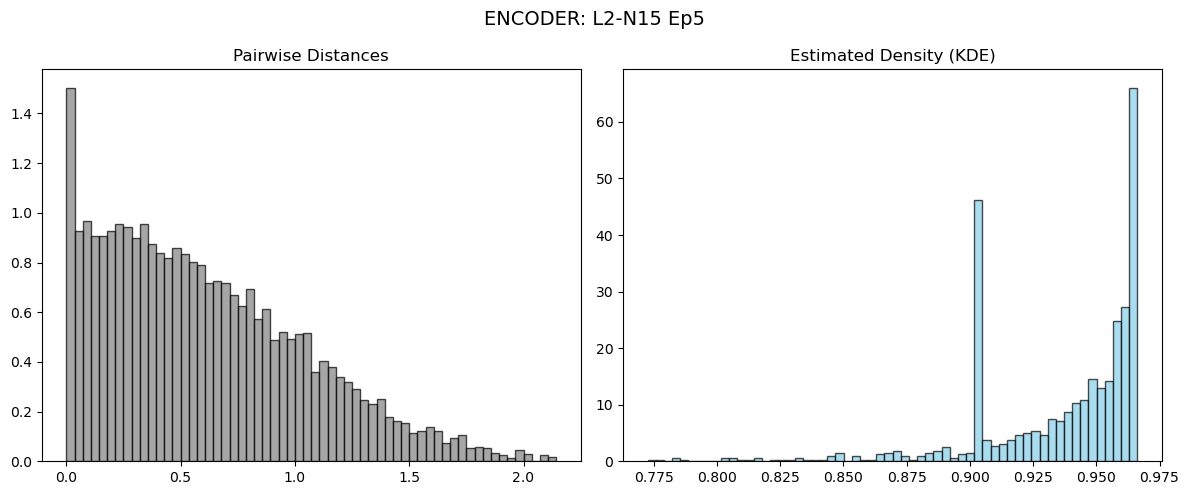

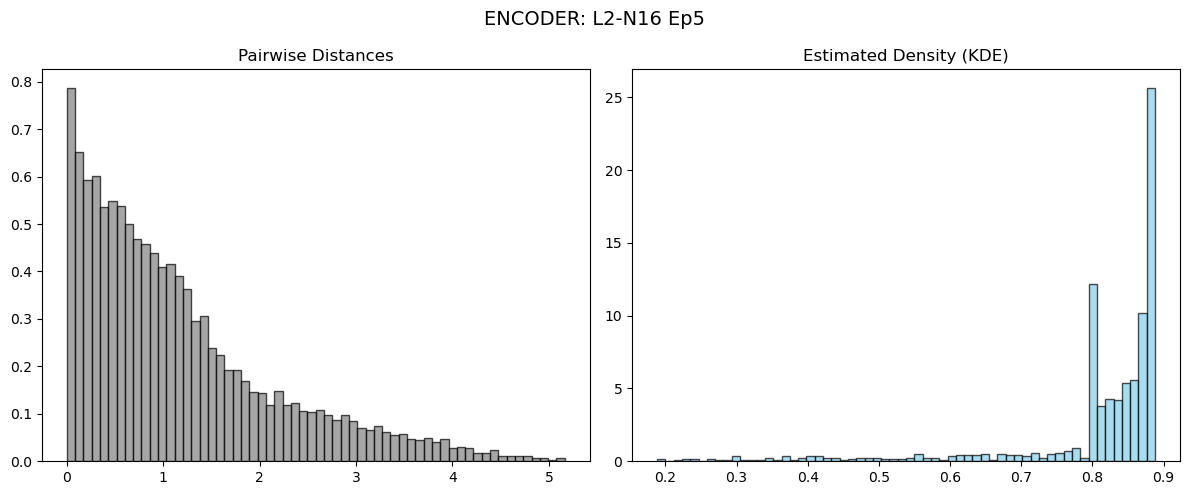

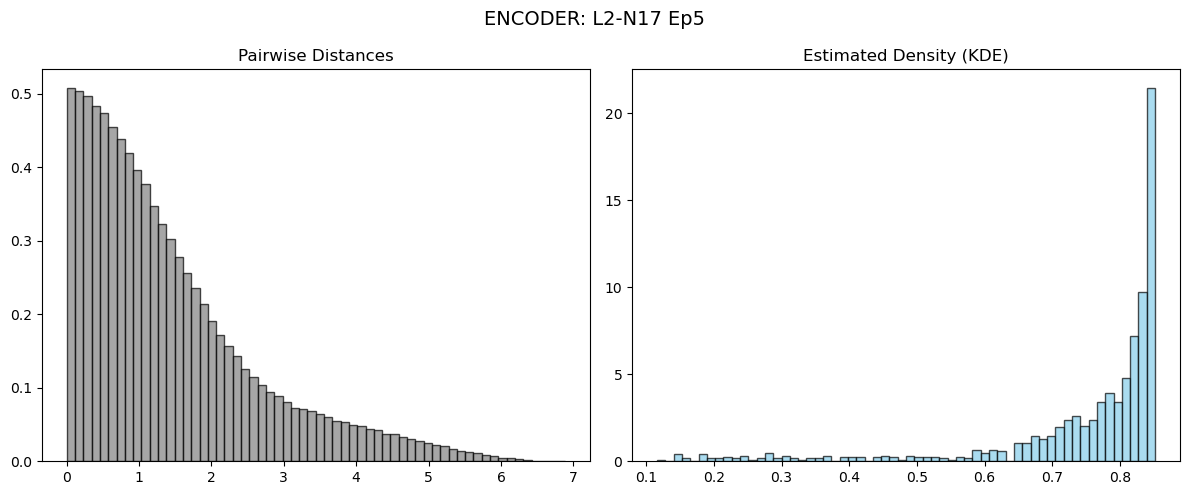

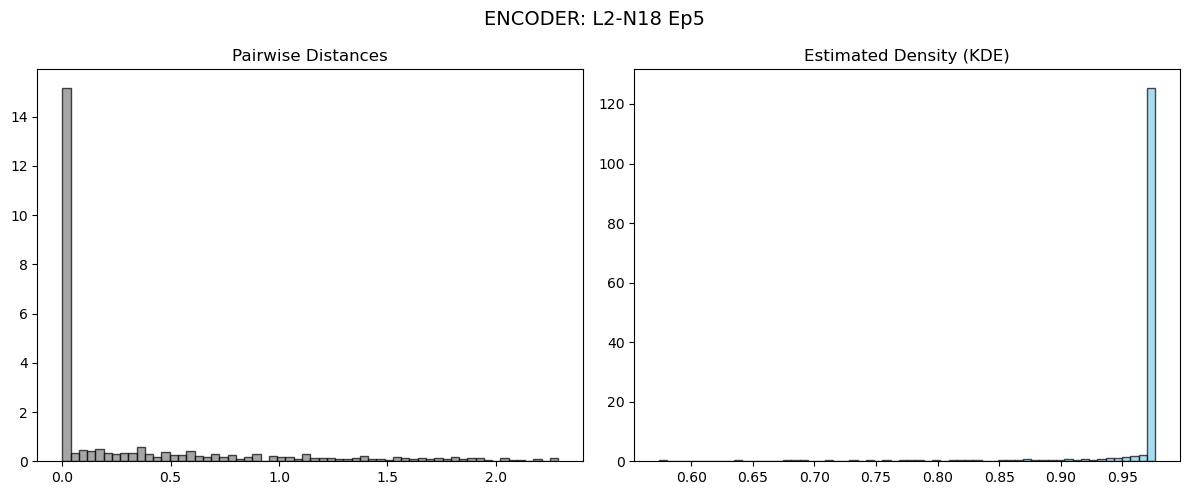

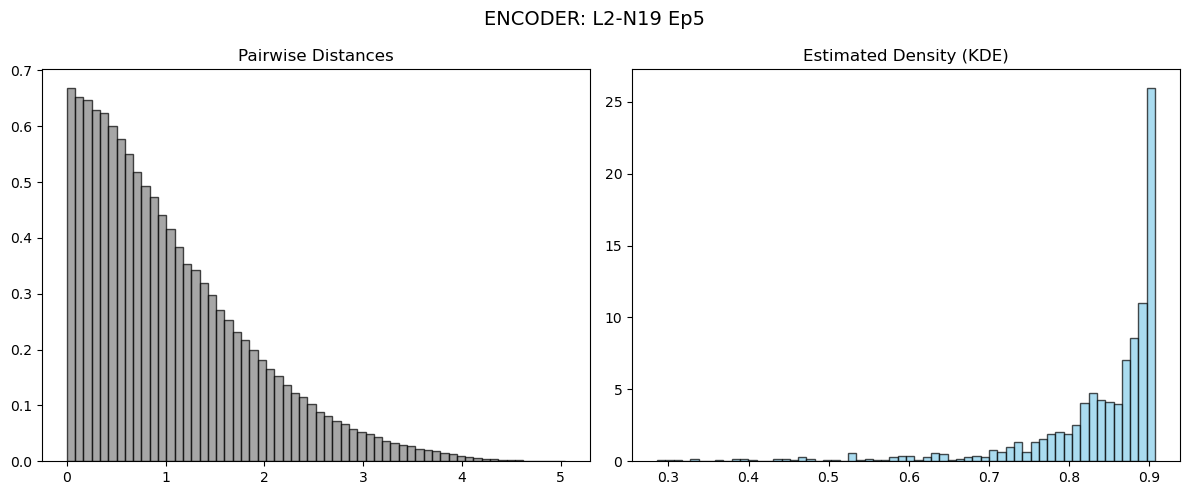

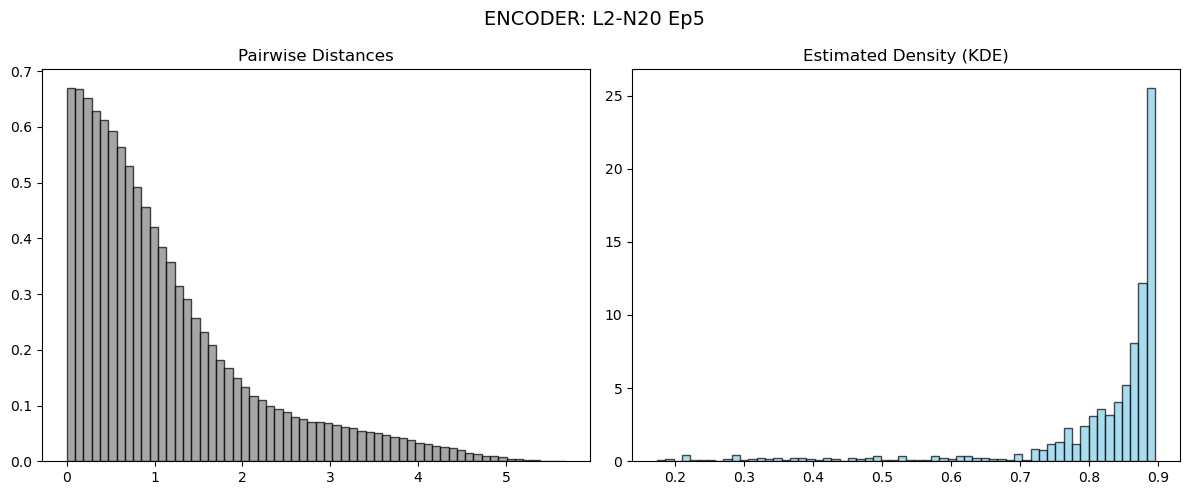

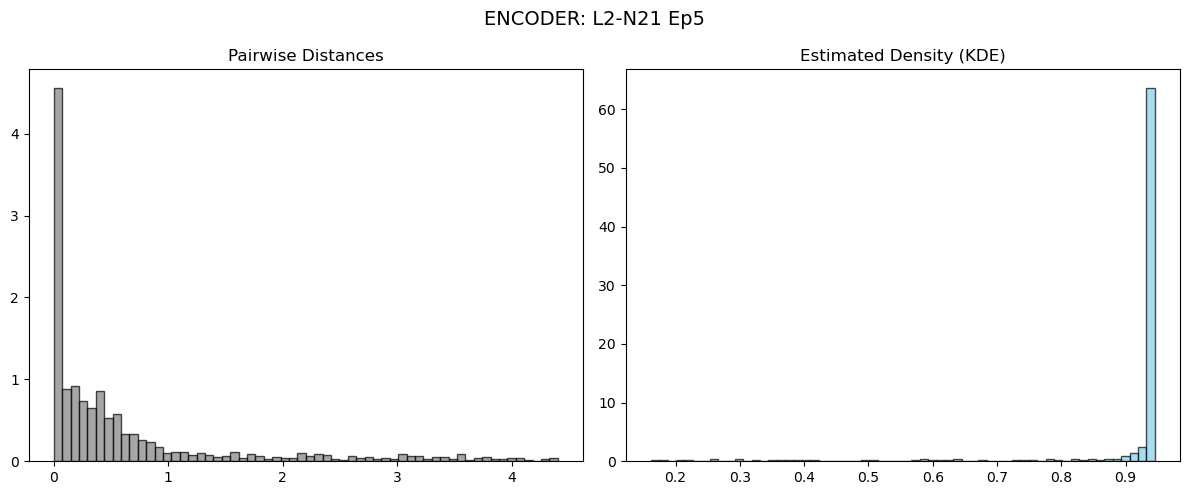

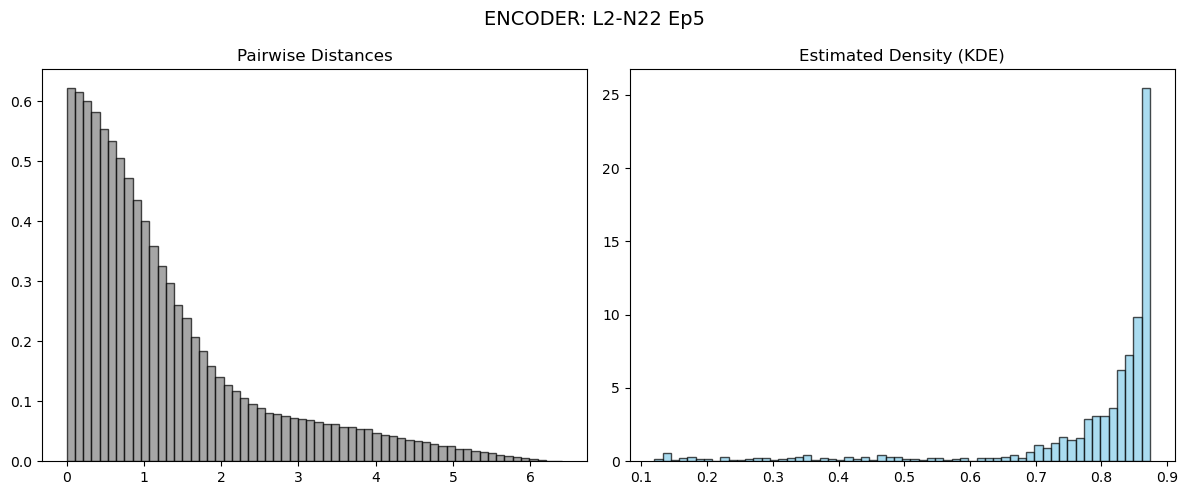

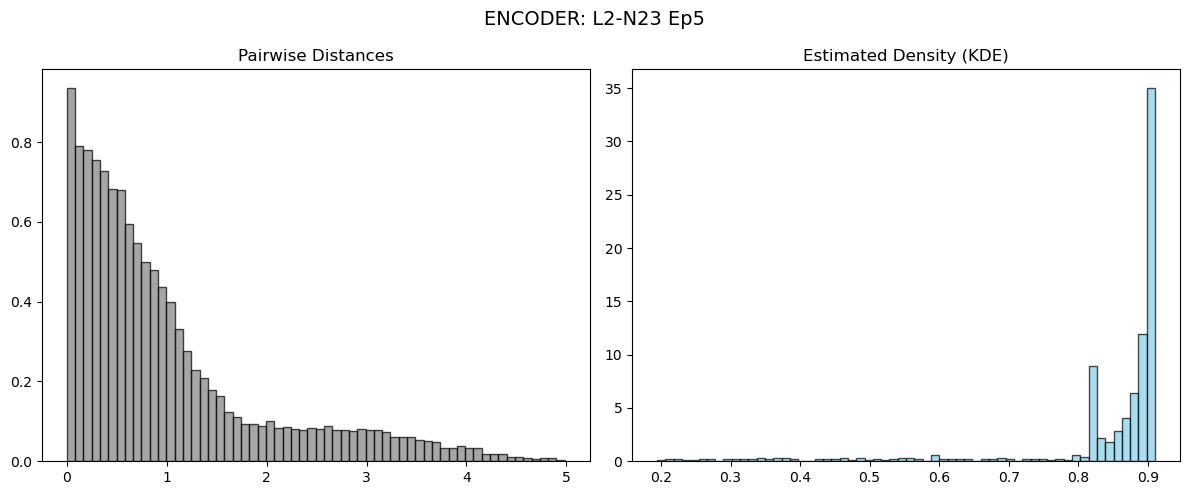

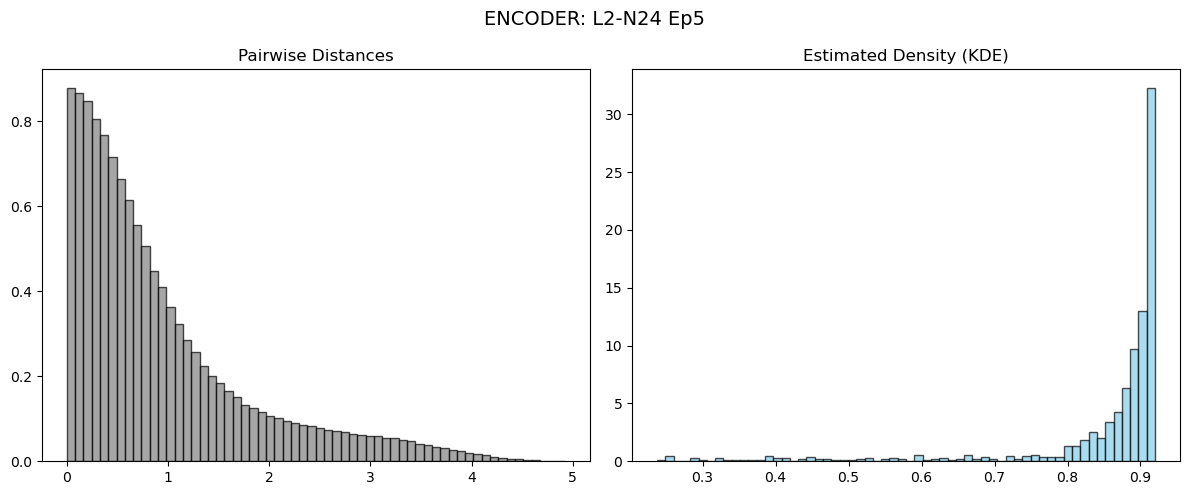

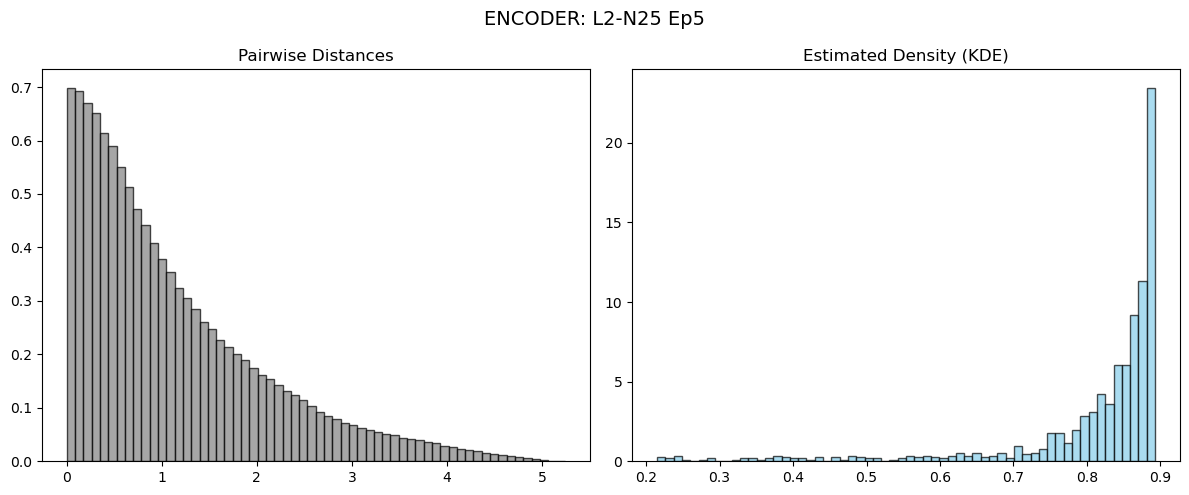

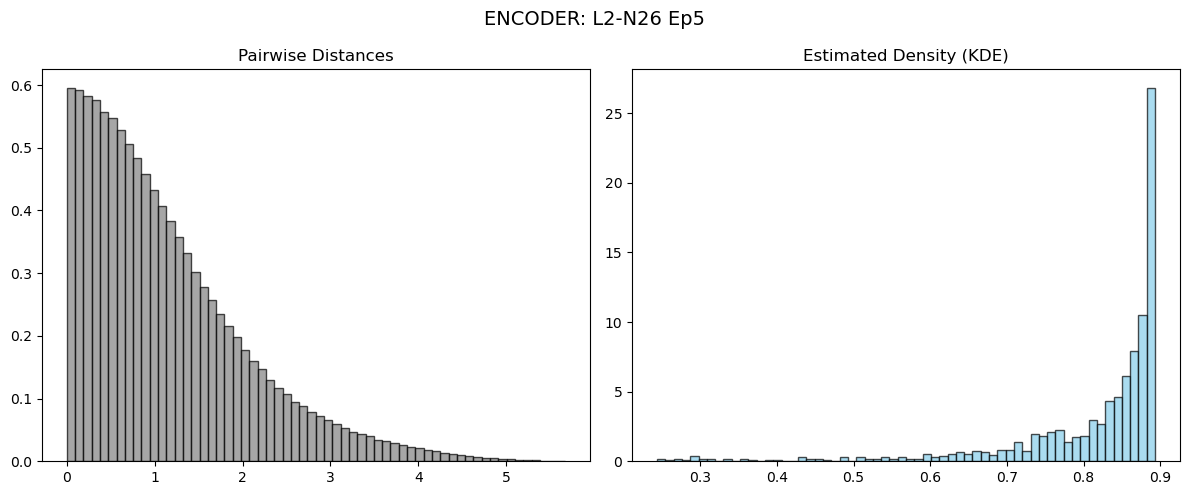

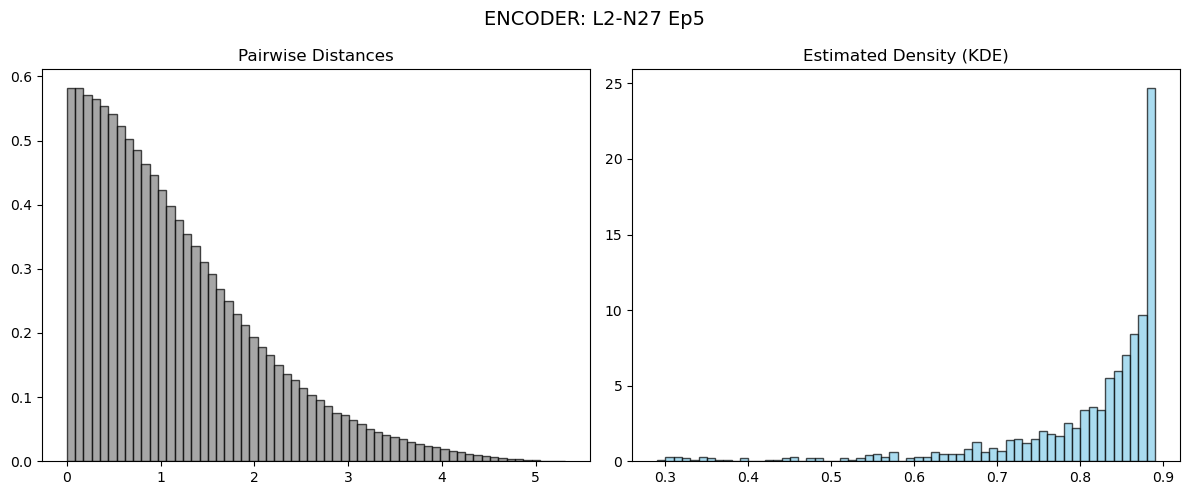

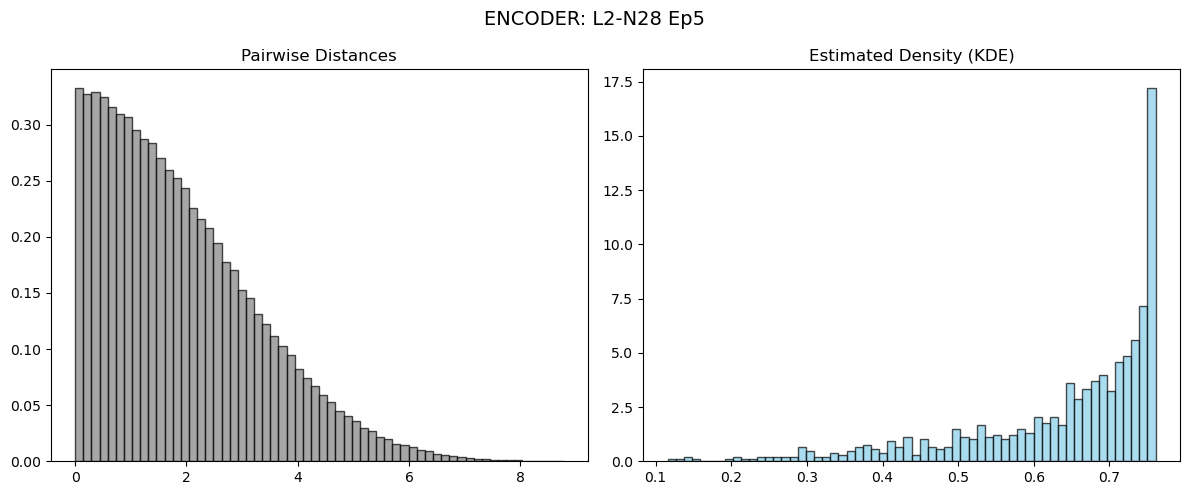

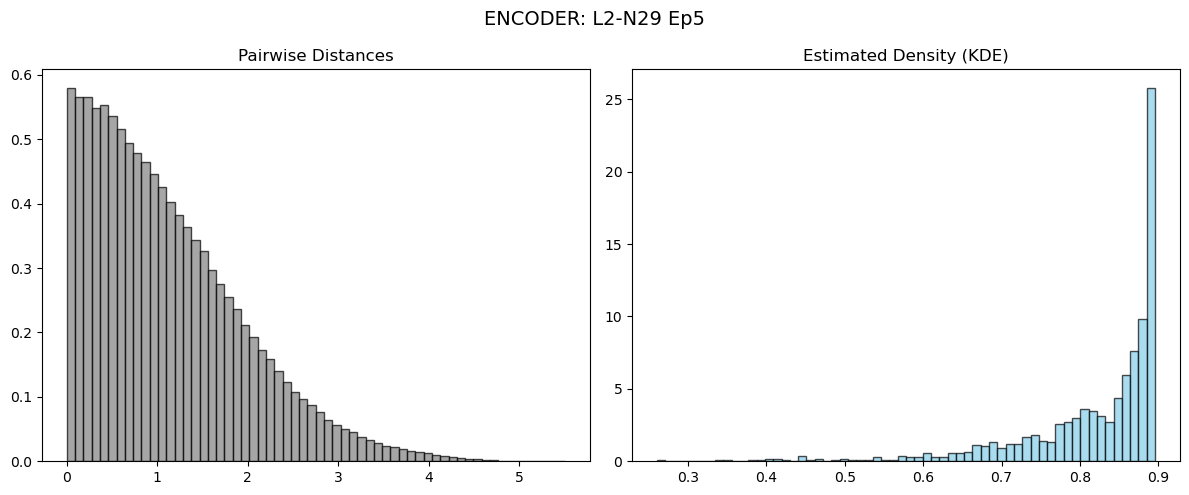

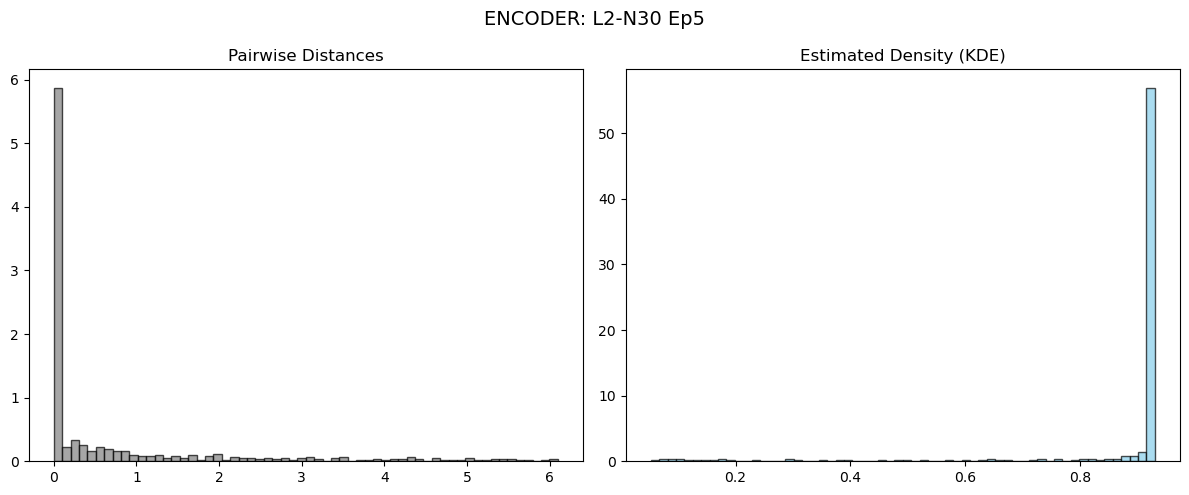

In [105]:
# # sui neuroni

# for neuron in range(1, 11):
#     plot_kde_geometry(
#         recorder=RecorderActivat,
#         mi_estimator=mi_estimator,
#         part="encoder",
#         layer=2,
#         neuron=neuron,
#         epoch=5
#     )

# 4. Results

## Mutual Information

In [106]:
def PlotInfoPlane(mi_history_encoder, mi_history_decoder, title_suffix="", start_epoch=1, end_epoch=-1, Step=5):

    fig = plt.figure(figsize=(16, 6))
    gs = fig.add_gridspec(1, 3, width_ratios=[6, 6, 0.2], wspace=0.3)

    ax_enc = fig.add_subplot(gs[0, 0])
    ax_dec = fig.add_subplot(gs[0, 1])
    ax_cb  = fig.add_subplot(gs[0, 2])

    total_epochs = len(mi_history_encoder)
    if end_epoch == -1 or end_epoch >= total_epochs:
        end_epoch = total_epochs -1

    # NEW: filter epochs by Step
    epoch_range = [ep for ep in range(start_epoch, end_epoch + 1) if ep % Step == 0]
    epochs = len(epoch_range)

    cmap = plt.get_cmap('viridis')
    colors = [cmap(i / max(1, epochs - 1)) for i in range(epochs)]

    encoder_markers = ['o', 's', '^', 'D', 'v', 'P', '*', 'X', '<', '>']
    decoder_markers = ['>', '*', 'p', 'X', 'H', '>', 'd', 'D', '8', 'o']

    n_layers = len(mi_history_encoder[0])

    # ---------------- ENCODER ----------------
    ax = ax_enc

    for ep_idx, ep in enumerate(epoch_range):
        x = [mi_history_encoder[ep][l][0] for l in range(n_layers)]
        y = [mi_history_encoder[ep][l][1] for l in range(n_layers)]

        ax.plot(x, y, linestyle='-', color=colors[ep_idx],
                alpha=0.6, linewidth=2)

        for l in range(n_layers):
            marker = encoder_markers[l % len(encoder_markers)]
            ax.scatter(x[l], y[l],
                       facecolors=[colors[ep_idx]],
                       edgecolors='black',
                       s=60, marker=marker,
                       linewidths=0.6, zorder=3)

    ax.set_xlabel("I(Layer; Input)", fontsize=14)
    ax.set_ylabel("I(Layer; Latent Z)", fontsize=14)
    ax.set_title(f"Encoder Information Plane {title_suffix}", fontsize=16)
    ax.grid(True, alpha=0.3)
    ax.tick_params(axis='both', labelsize=12)

    enc_handles = []
    enc_labels = []
    for l in range(n_layers):
        mk = encoder_markers[l % len(encoder_markers)]
        handle = Line2D([0], [0], marker=mk, color='black',
                        markerfacecolor='black',
                        markeredgecolor='black',
                        markersize=10, linestyle='None')
        enc_handles.append(handle)
        enc_labels.append(f'Layer {l+1}')

    ax_enc.legend(enc_handles, enc_labels, framealpha=0.9, fontsize=12, title_fontsize=13)

    # ---------------- DECODER ----------------
    ax = ax_dec

    for ep_idx, ep in enumerate(epoch_range):
        x = [mi_history_decoder[ep][l][0] for l in range(n_layers)]
        y = [mi_history_decoder[ep][l][1] for l in range(n_layers)]

        ax.plot(x, y, linestyle='-', color=colors[ep_idx],
                alpha=0.6, linewidth=2)

        for l in range(n_layers):
            marker = decoder_markers[l % len(decoder_markers)]
            ax.scatter(x[l], y[l],
                       facecolors=[colors[ep_idx]],
                       edgecolors='black',
                       s=60, marker=marker,
                       linewidths=0.6, zorder=3)

    ax.set_xlabel("I(Layer; Latent Z)", fontsize=14)
    ax.set_ylabel("I(Layer; Output)", fontsize=14)
    ax.set_title(f"Decoder Information Plane {title_suffix}", fontsize=16)
    ax.grid(True, alpha=0.3)
    ax.tick_params(axis='both', labelsize=12)

    dec_handles = []
    dec_labels = []
    for l in range(n_layers):
        mk = decoder_markers[l % len(decoder_markers)]
        handle = Line2D([0], [0], marker=mk, color='black',
                        markerfacecolor='black',
                        markeredgecolor='black',
                        markersize=10, linestyle='None')
        dec_handles.append(handle)
        dec_labels.append(f'Layer {l+1}')

    ax_dec.legend(dec_handles, dec_labels, framealpha=0.9, fontsize=12, title_fontsize=13)

    # ---------------- COLORBAR ----------------
    norm = Normalize(vmin=start_epoch, vmax=end_epoch)
    sm = cm.ScalarMappable(cmap=cmap, norm=norm)
    sm.set_array([])

    cbar = fig.colorbar(sm, cax=ax_cb, orientation='vertical')
    cbar.set_ticks(epoch_range)
    cbar.set_ticklabels(epoch_range)
    cbar.set_label("Epoch", fontsize=14)

    plt.show()

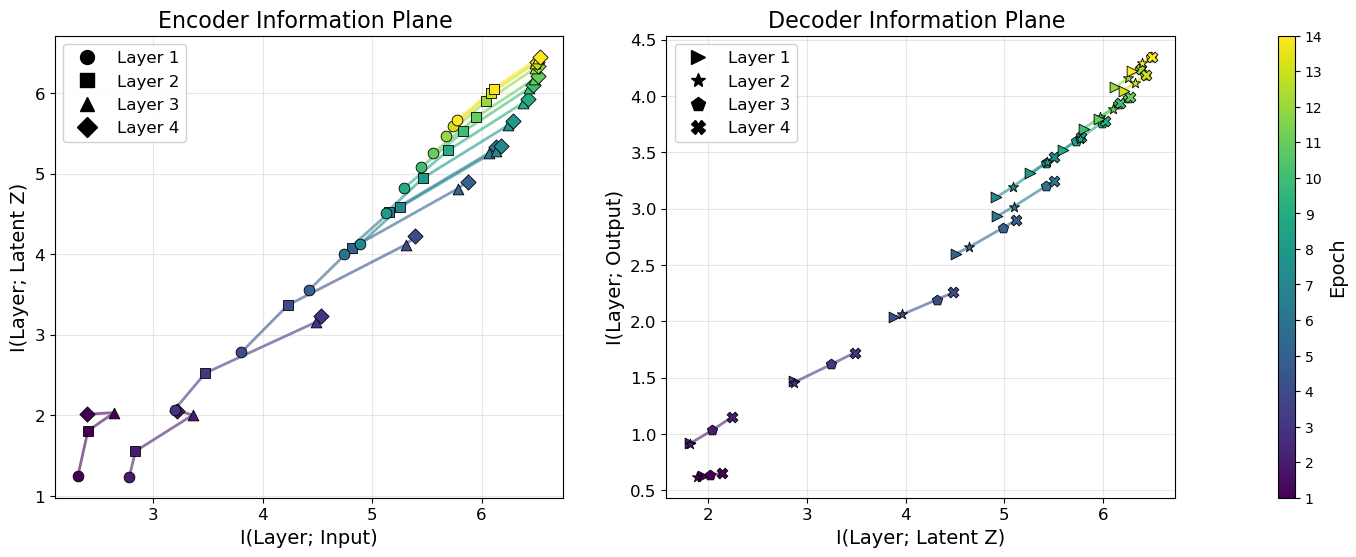

In [107]:
# Variational
PlotInfoPlane(mi_history.encoder, mi_history.decoder, start_epoch=1, end_epoch=-1, Step=1)

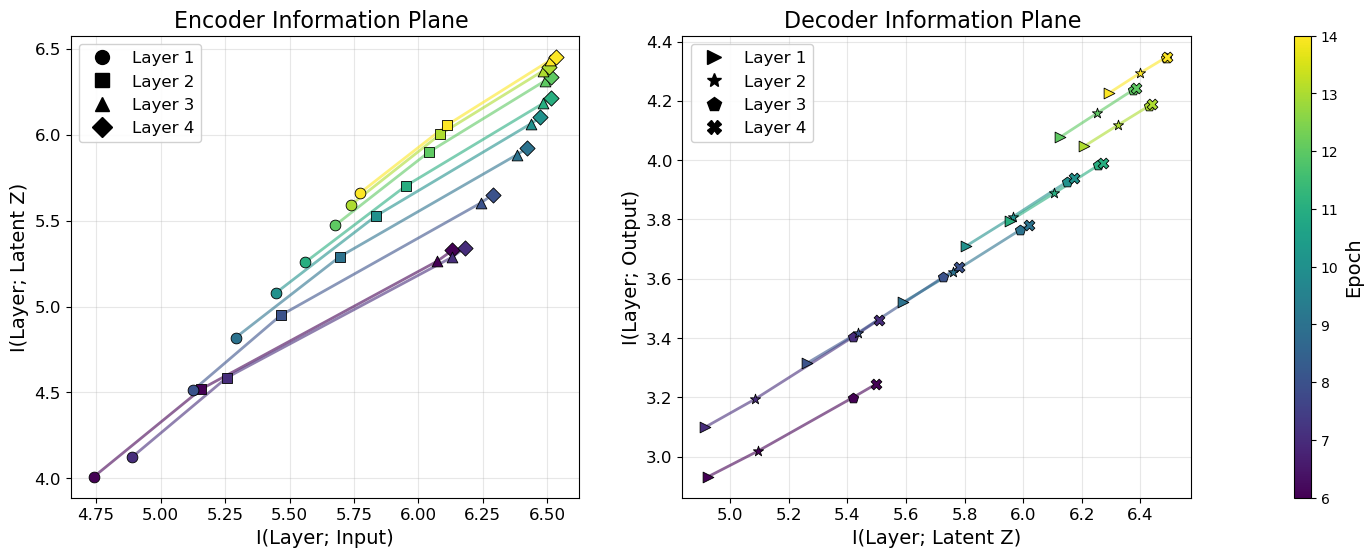

In [108]:
# Variational
PlotInfoPlane(mi_history.encoder, mi_history.decoder, start_epoch=6, end_epoch=15, Step=1)

## VAE outputs

In [109]:
def ShowSomeImages(model, testDataset, device):

    model.eval()
    fig, axs = plt.subplots(5, 2, figsize=(6, 12))

    for i in range(5):
        img, _ = random.choice(testDataset)

        x = img.unsqueeze(0).to(device)

        with torch.no_grad():
            recon, _, _, _ = model(x)

        original = img.cpu().squeeze().numpy()
        reconstructed = recon.cpu().squeeze().numpy().reshape(28, 28)

        axs[i, 0].imshow(original, cmap="gist_gray")
        axs[i, 0].set_title("Original")
        axs[i, 0].set_xticks([])
        axs[i, 0].set_yticks([])

        axs[i, 1].imshow(reconstructed, cmap="gist_gray")
        axs[i, 1].set_title("Reconstruction")
        axs[i, 1].set_xticks([])
        axs[i, 1].set_yticks([])

    plt.tight_layout()
    plt.show()

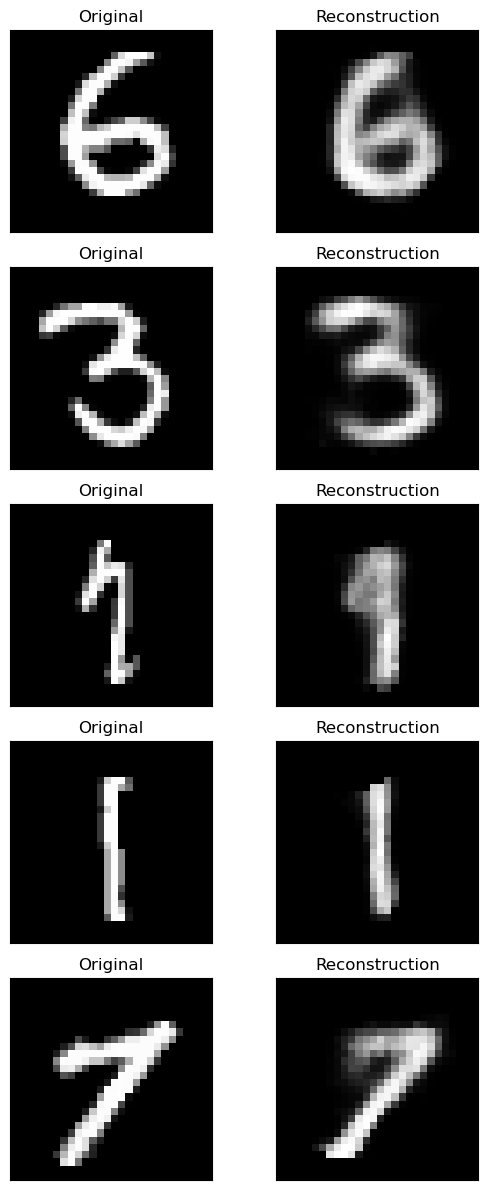

In [110]:
ShowSomeImages(model, testDataset, device)

## VAE loss

In [111]:
model.train_loss_history

[0.10131121849020322,
 0.06410980025927225,
 0.05919993110001087,
 0.05391681774829825,
 0.04873211979866028,
 0.04399988241493702,
 0.04015347448488076,
 0.03797478520621856,
 0.036360972374677655,
 0.034771123932053644,
 0.03355811424553394,
 0.03253605294351777,
 0.031586286658421156,
 0.030793118787308536,
 0.030105280984813968]

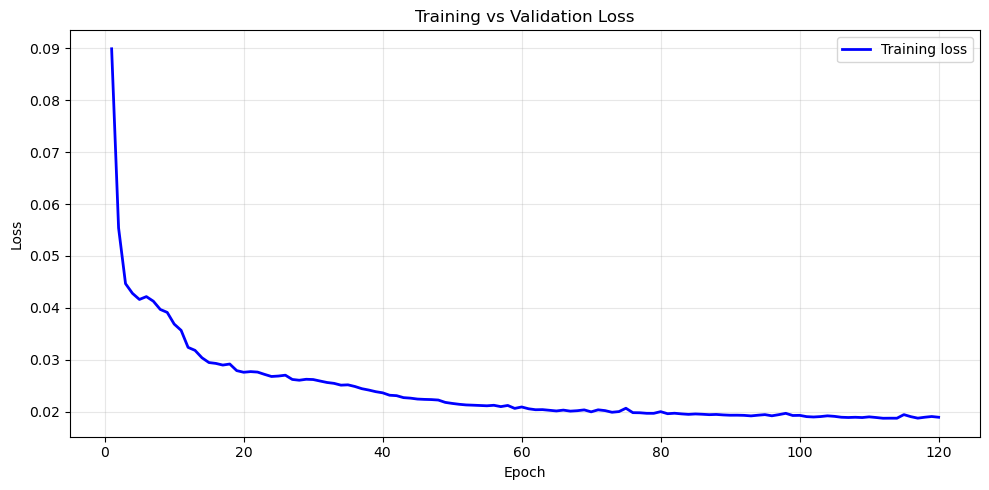

In [50]:
model.plot_loss()

--------

# Studying $\tanh$ activation

In [126]:
#Define the Dataloader
trainDataloader = DataLoader(trainDataset, batch_size=128, shuffle=True)
testDataloader = DataLoader(testDataset, batch_size=128, shuffle=False)

batch_data, batch_labels = next(iter(trainDataloader))
print(f"TRAIN BATCH SHAPE")
print(f"\t Data: {batch_data.shape}")
print(f"\t Labels: {batch_labels.shape}")

batch_data, batch_labels = next(iter(testDataloader))
print(f"TEST BATCH SHAPE")
print(f"\t Data: {batch_data.shape}")
print(f"\t Labels: {batch_labels.shape}")

TRAIN BATCH SHAPE
	 Data: torch.Size([128, 1, 28, 28])
	 Labels: torch.Size([128])
TEST BATCH SHAPE
	 Data: torch.Size([128, 1, 28, 28])
	 Labels: torch.Size([128])


In [127]:
tanh_model = VariationalAutoEncoder(latentDim = 10,
                               hiddenDim=[200, 150, 100, 50],
                               activation_enc=nn.Tanh,
                               activation_dec=nn.Tanh,
                               Variational = True
                              )

tanh_model.to(device)

VariationalAutoEncoder(
  (InputSpace): Identity()
  (Encoder): Sequential(
    (0): Sequential(
      (0): Linear(in_features=784, out_features=200, bias=True)
      (1): Tanh()
    )
    (1): Sequential(
      (0): Linear(in_features=200, out_features=150, bias=True)
      (1): Tanh()
    )
    (2): Sequential(
      (0): Linear(in_features=150, out_features=100, bias=True)
      (1): Tanh()
    )
    (3): Sequential(
      (0): Linear(in_features=100, out_features=50, bias=True)
      (1): Tanh()
    )
  )
  (LatentLayerMu): Linear(in_features=50, out_features=10, bias=True)
  (LatentLayerSigma): Linear(in_features=50, out_features=10, bias=True)
  (LatentSpace): Identity()
  (Decoder): Sequential(
    (0): Sequential(
      (0): Linear(in_features=10, out_features=50, bias=True)
      (1): Tanh()
    )
    (1): Sequential(
      (0): Linear(in_features=50, out_features=100, bias=True)
      (1): Tanh()
    )
    (2): Sequential(
      (0): Linear(in_features=100, out_features=150, 

In [128]:
# same implementation as above
optimizer = torch.optim.Adam(tanh_model.parameters(), lr=5e-4)
loss_fn = torch.nn.MSELoss()

# global usefull elements
epochs = 20

method_mi="kde"
sigmaKDE = 2
n_neigKRASKOV = 3

RecorderActivat = ActivationRecorder()
mi_history = MI_History()
mi_estimator = MI_Estimator( method=method_mi, sigma=sigmaKDE, n_neig=n_neigKRASKOV )

In [129]:
#---------- TRAINING ------------
final_loss = Training(
    tanh_model,
    optimizer,
    loss_fn,
    num_epochs=epochs, 
    sampleMI=1000,
    mi_estimator=mi_estimator,
    showImage=False,
    doTest=False
)

Epoch 1/20: 100%|██████████| 469/469 [00:06<00:00, 70.81it/s]


Epoch 1 — train: 0.0730


Epoch 2/20: 100%|██████████| 469/469 [00:05<00:00, 85.95it/s]


Epoch 2 — train: 0.0674


Epoch 3/20: 100%|██████████| 469/469 [00:05<00:00, 85.55it/s]


Epoch 3 — train: 0.0674


Epoch 4/20: 100%|██████████| 469/469 [00:05<00:00, 82.48it/s]


Epoch 4 — train: 0.0640


Epoch 5/20: 100%|██████████| 469/469 [00:05<00:00, 84.26it/s]


Epoch 5 — train: 0.0556


Epoch 6/20: 100%|██████████| 469/469 [00:05<00:00, 85.09it/s]


Epoch 6 — train: 0.0519


Epoch 7/20: 100%|██████████| 469/469 [00:05<00:00, 83.49it/s]


Epoch 7 — train: 0.0498


Epoch 8/20: 100%|██████████| 469/469 [00:05<00:00, 85.26it/s]


Epoch 8 — train: 0.0485


Epoch 9/20: 100%|██████████| 469/469 [00:05<00:00, 85.22it/s]


Epoch 9 — train: 0.0475


Epoch 10/20: 100%|██████████| 469/469 [00:05<00:00, 82.00it/s]


Epoch 10 — train: 0.0467


Epoch 11/20: 100%|██████████| 469/469 [00:05<00:00, 84.79it/s]


Epoch 11 — train: 0.0444


Epoch 12/20: 100%|██████████| 469/469 [00:05<00:00, 84.75it/s]


Epoch 12 — train: 0.0409


Epoch 13/20: 100%|██████████| 469/469 [00:05<00:00, 84.99it/s]


Epoch 13 — train: 0.0382


Epoch 14/20: 100%|██████████| 469/469 [00:05<00:00, 83.36it/s]


Epoch 14 — train: 0.0360


Epoch 15/20: 100%|██████████| 469/469 [00:06<00:00, 71.73it/s]


Epoch 15 — train: 0.0341


Epoch 16/20: 100%|██████████| 469/469 [00:05<00:00, 82.69it/s]


Epoch 16 — train: 0.0322


Epoch 17/20: 100%|██████████| 469/469 [00:05<00:00, 83.74it/s]


Epoch 17 — train: 0.0310


Epoch 18/20: 100%|██████████| 469/469 [00:05<00:00, 85.00it/s]


Epoch 18 — train: 0.0300


Epoch 19/20: 100%|██████████| 469/469 [00:05<00:00, 85.19it/s]


Epoch 19 — train: 0.0291


Epoch 20/20: 100%|██████████| 469/469 [00:05<00:00, 85.68it/s]


Epoch 20 — train: 0.0280


In [130]:
#--------- DIAGNOSTIC ------------
mi_history.show("encoder")

==================== MI HISTORY (encoder) ====================
EPOCH 1
  [Encoder]
    Layer 1: I(Input, L)=0.487 | I(L, Z)=0.000
    Layer 2: I(Input, L)=0.023 | I(L, Z)=0.000
    Layer 3: I(Input, L)=0.001 | I(L, Z)=0.000
    Layer 4: I(Input, L)=0.000 | I(L, Z)=0.000
--------------------------------------------------
EPOCH 2
  [Encoder]
    Layer 1: I(Input, L)=0.506 | I(L, Z)=0.001
    Layer 2: I(Input, L)=0.024 | I(L, Z)=0.000
    Layer 3: I(Input, L)=0.001 | I(L, Z)=0.000
    Layer 4: I(Input, L)=0.000 | I(L, Z)=0.000
--------------------------------------------------
EPOCH 3
  [Encoder]
    Layer 1: I(Input, L)=0.519 | I(L, Z)=0.000
    Layer 2: I(Input, L)=0.028 | I(L, Z)=-0.000
    Layer 3: I(Input, L)=0.003 | I(L, Z)=-0.000
    Layer 4: I(Input, L)=0.000 | I(L, Z)=-0.000
--------------------------------------------------
EPOCH 4
  [Encoder]
    Layer 1: I(Input, L)=2.093 | I(L, Z)=0.505
    Layer 2: I(Input, L)=1.220 | I(L, Z)=0.457
    Layer 3: I(Input, L)=0.738 | I(L, Z)=0.

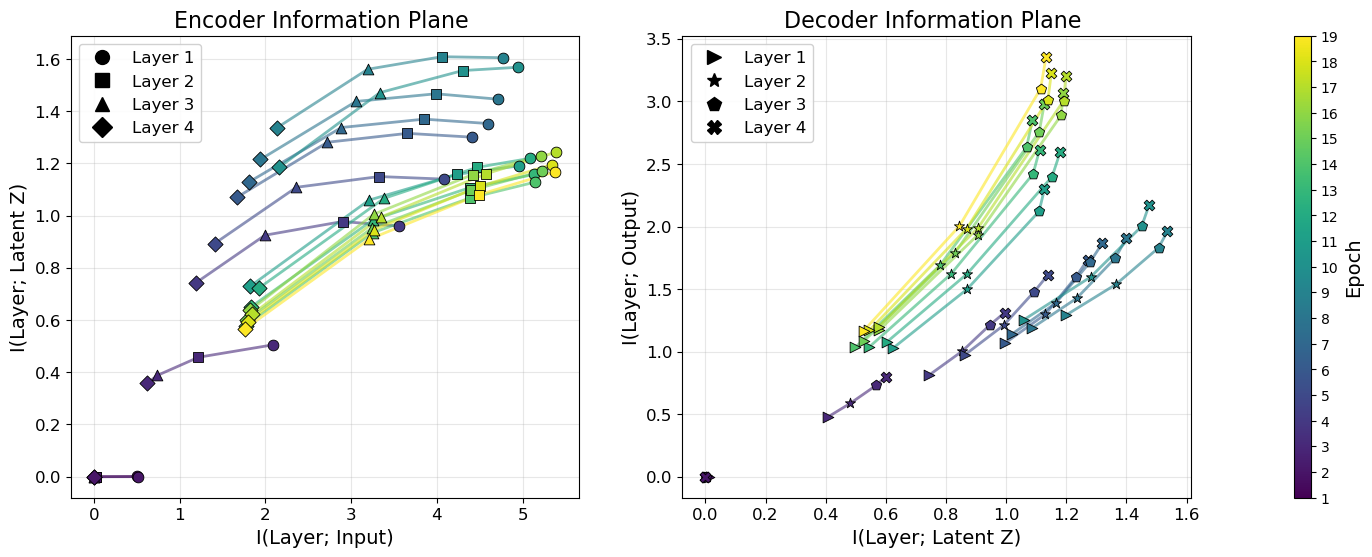

In [131]:
# Variational
PlotInfoPlane(mi_history.encoder, mi_history.decoder, start_epoch=1, end_epoch=epochs, Step=1)

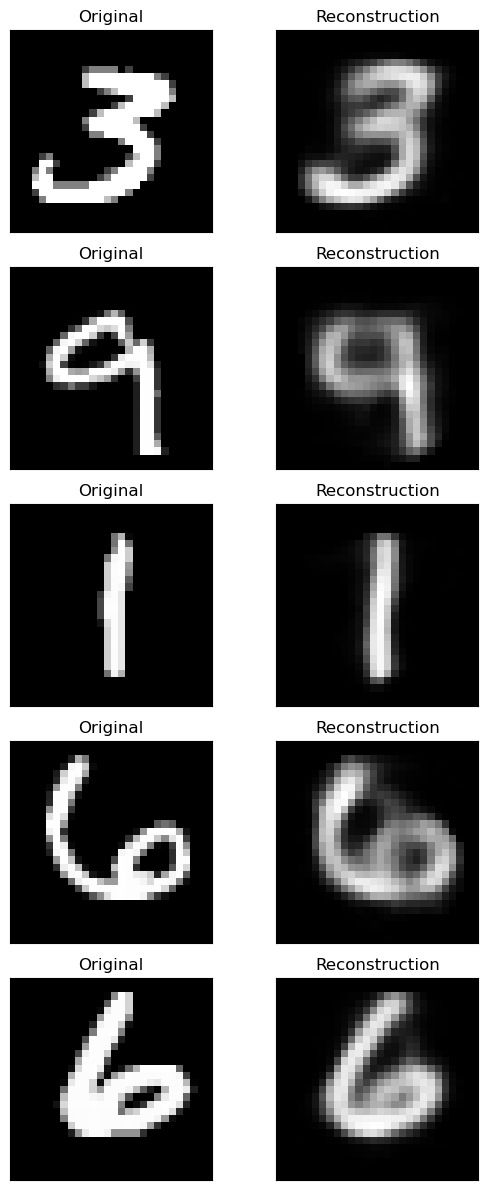

In [125]:
ShowSomeImages(tanh_model, testDataset, device)

--------

# 11.(mio numero preferito) ---------------ROBA VECCHIA------------ codice funzioni c'è su github se serve

In [40]:
# Variational
PlotInfoPlane(history_encoder, history_decoder, start_epoch=6, end_epoch=40, Step=2)

NameError: name 'history_encoder' is not defined

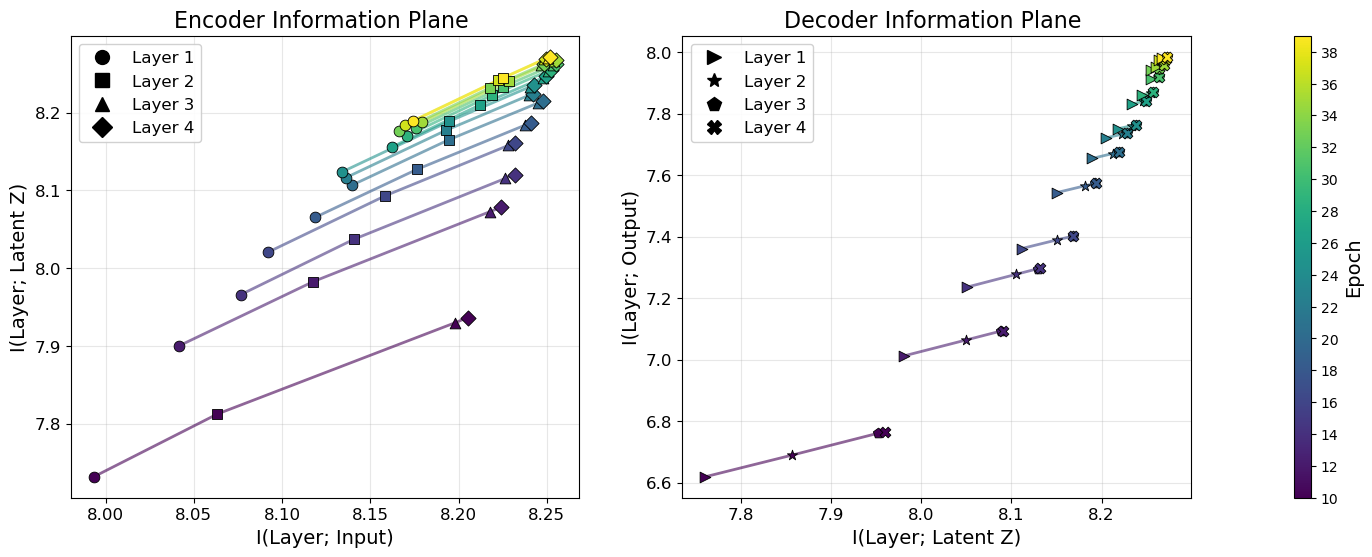

In [ ]:
# Variational
PlotInfoPlane(history_encoder, history_decoder, start_epoch=10, end_epoch=40, Step=2)

In [ ]:
def PlotInfoPlaneLayers(mi_history_encoder, mi_history_decoder,
                            title_suffix="",
                            start_epoch=1, end_epoch=-1, Step=1):
    import matplotlib.pyplot as plt
    from matplotlib.lines import Line2D

    # --- Select epochs based on user settings ---
    total_epochs = len(mi_history_encoder)
    if end_epoch == -1 or end_epoch >= total_epochs:
        end_epoch = total_epochs - 1

    # Filter epochs: start → end, stepping by Step
    epoch_range = [ep for ep in range(start_epoch, end_epoch + 1) if (ep - start_epoch) % Step == 0]

    # --- Figure layout ---
    fig = plt.figure(figsize=(16, 6))
    gs = fig.add_gridspec(1, 2, width_ratios=[6, 6], wspace=0.3)

    ax_enc = fig.add_subplot(gs[0, 0])
    ax_dec = fig.add_subplot(gs[0, 1])

    n_layers = len(mi_history_encoder[0])

    # ----- Color scales -----
    encoder_colors = [plt.cm.Reds((i+1)/n_layers) for i in range(n_layers)]
    decoder_colors = [plt.cm.Blues((i+1)/n_layers) for i in range(n_layers)]

    # marker shapes
    markers = ['o', 's', '^', 'D', 'v', 'P', '*', 'X', '<', '>']

    # ---------------- ENCODER ----------------
    for l in range(n_layers):
        x = [mi_history_encoder[ep][l][0] for ep in epoch_range]
        y = [mi_history_encoder[ep][l][1] for ep in epoch_range]

        ax_enc.scatter(
            x, y,
            s=60,
            marker=markers[l % len(markers)],
            facecolors=encoder_colors[l],
            edgecolors='black',
            linewidths=0.6
        )

    ax_enc.set_xlabel("I(Layer; Input)", fontsize=14)
    ax_enc.set_ylabel("I(Layer; Latent Z)", fontsize=14)
    ax_enc.set_title(f"Encoder Information Plane {title_suffix}", fontsize=16)
    ax_enc.grid(True, alpha=0.3)
    ax_enc.tick_params(axis='both', labelsize=12)

    # Encoder legend
    enc_handles = [
        Line2D([0], [0],
               marker=markers[l % len(markers)],
               color='black',
               markerfacecolor=encoder_colors[l],
               markeredgecolor='black',
               markersize=10,
               linestyle='None')
        for l in range(n_layers)
    ]
    ax_enc.legend(enc_handles, [f"Layer {l+1}" for l in range(n_layers)],
                  framealpha=0.9, fontsize=12, title_fontsize=13)

    # ---------------- DECODER ----------------
    for l in range(n_layers):
        x = [mi_history_decoder[ep][l][0] for ep in epoch_range]
        y = [mi_history_decoder[ep][l][1] for ep in epoch_range]

        ax_dec.scatter(
            x, y,
            s=60,
            marker=markers[l % len(markers)],
            facecolors=decoder_colors[l],
            edgecolors='black',
            linewidths=0.6
        )

    ax_dec.set_xlabel("I(Layer; Latent Z)", fontsize=14)
    ax_dec.set_ylabel("I(Layer; Output)", fontsize=14)
    ax_dec.set_title(f"Decoder Information Plane {title_suffix}", fontsize=16)
    ax_dec.grid(True, alpha=0.3)
    ax_dec.tick_params(axis='both', labelsize=12)

    # Decoder legend
    dec_handles = [
        Line2D([0], [0],
               marker=markers[l % len(markers)],
               color='black',
               markerfacecolor=decoder_colors[l],
               markeredgecolor='black',
               markersize=10,
               linestyle='None')
        for l in range(n_layers)
    ]
    ax_dec.legend(dec_handles, [f"Layer {l+1}" for l in range(n_layers)],
                  framealpha=0.9, fontsize=12, title_fontsize=13)

    plt.show()

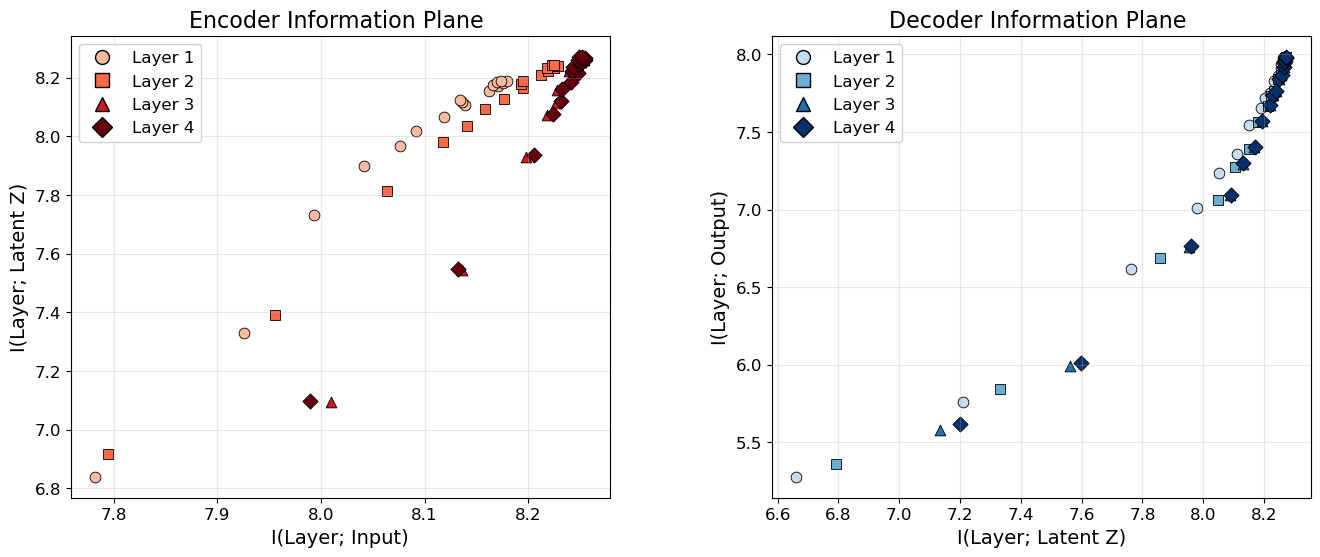

In [ ]:
# No variation 80 epoch
PlotInfoPlaneLayers(history_encoder, history_decoder, start_epoch=6, end_epoch=40, Step=2)

In [ ]:
def PlotInputLatentOutput(mi_input_latent, mi_latent_output, title_suffix="", start_epoch=1, end_epoch=-1, Step=5):

    # --- Determine epoch range ---
    total_epochs = len(mi_input_latent)
    if end_epoch == -1 or end_epoch >= total_epochs:
        end_epoch = total_epochs - 1

    epoch_range = [ep for ep in range(start_epoch, end_epoch + 1)
                   if ep % Step == 0]

    # --- Extract MI values for selected epochs ---
    X_vals = [mi_input_latent[ep] for ep in epoch_range]
    Y_vals = [mi_latent_output[ep] for ep in epoch_range]

    cmap = plt.get_cmap("Greens")
    colors = [cmap(i / max(1, len(epoch_range) - 1)) for i in range(len(epoch_range))]

    fig, ax = plt.subplots(figsize=(7, 6))

    for i, ep in enumerate(epoch_range):
        ax.scatter(
            X_vals[i], Y_vals[i],
            s=80,
            marker='o',
            facecolors=colors[i],
            edgecolors='black',
            linewidths=0.6,
            label=f"Epoch {ep}"
        )

    # Labels and title
    ax.set_xlabel("MI(Input; Latent)", fontsize=14)
    ax.set_ylabel("MI(Latent; Output)", fontsize=14)
    ax.set_title(f"Global Mutual Information {title_suffix}", fontsize=16)
    ax.grid(True, alpha=0.3)
    ax.tick_params(axis='both', labelsize=12)

    # --- Colorbar ---
    norm = Normalize(vmin=start_epoch, vmax=end_epoch)
    sm = cm.ScalarMappable(cmap=cmap, norm=norm)
    sm.set_array([])

    cbar = plt.colorbar(sm, ax=ax)
    cbar.set_label("Epoch", fontsize=14)
    cbar.set_ticks(epoch_range)
    cbar.set_ticklabels(epoch_range)

    plt.tight_layout()
    plt.show()

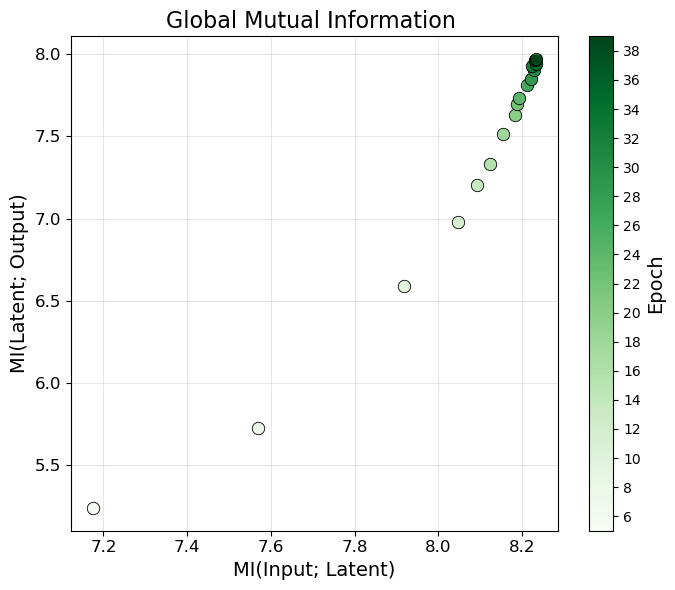

In [ ]:
# Variation 40 epoch
PlotInputLatentOutput(history_input_latent, history_latent_output, start_epoch=5, end_epoch=40, Step=2)